In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

import dask.dataframe as dd
import dask.array as da
# import dask.bag as db
import dask
from dask.distributed import Client, SSHCluster
import dask.distributed

# import hvplot.dask

In [ ]:
import glob
dir_path = '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_*'
dir_list = glob.glob(dir_path)
print(len(dir_list))

60


In [ ]:
output_column_to_remove = ['ID', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0','RCO_0', 'Luminosity_0', 'Temperature_0', 'Lambda_0',
                               'Phase_0', 'PhaseBSE_0', 'Zams_0', 'MHE_1', 'MCO_1','Radius_1', 'RHE_1', 'RCO_1', 
                               'Luminosity_1', 'Temperature_1','Lambda_1', 'Phase_1', 'PhaseBSE_1', 'Zams_1']
    
evolved_column_to_remove = ['#ID', 'spin_0', 'Tstart_0', 'spin_1', 'Tstart_1', 'Tend', 'Dtout', 'Seed']
drop_list = ['RemnantType_0',  'RemnantType_1']

In [ ]:
def FGpreprocessing(dir_path: str, n_thread: int, output_column_to_remove: list, evolved_column_to_remove: list, drop_list: list):
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#     Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()

    ##################################

    

    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

# Benchmark Workers Threads

In [ ]:
attempt = 10
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files_10/Benchmark_Workers_Threads_10.npy', time_list)

# Plot

 ## Matplotlib 

In [ ]:
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')
array

array([[[496.18939042, 309.44374251, 363.26255941],
        [383.50346351, 403.58574152, 335.96760678],
        [249.42443776, 225.85286474, 201.97225642]],

       [[430.55225253, 284.76588345, 269.20183468],
        [327.67098856, 248.67283058, 244.65126681],
        [303.31334281, 346.56437111, 368.19598842]],

       [[580.6985929 , 411.72727776, 288.80423403],
        [403.49360991, 337.66984129, 315.66719437],
        [323.27917314, 249.95861268, 245.46395135]],

       [[512.35118294, 369.4232645 , 321.72102141],
        [360.65168834, 272.86523509, 250.48180246],
        [339.16766191, 271.98966718, 191.38780403]],

       [[384.58253169, 251.22575355, 222.65730762],
        [220.56649065, 187.8428731 , 157.14735389],
        [167.94112587, 202.3636508 , 209.33047056]]])

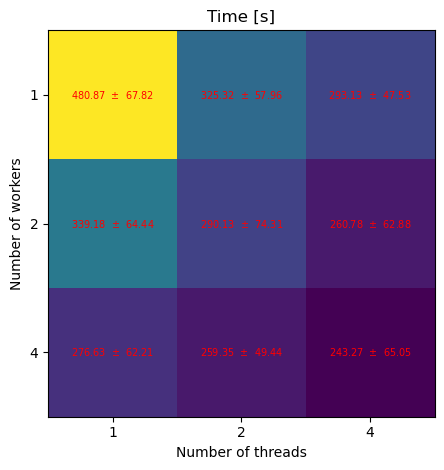

<Figure size 640x480 with 0 Axes>

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, r'%.2f  $\pm$  %.2f' % (mean[w,t], std[w,t]),
                       ha="center", va="center", color="red", fontsize=7)

ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Time [s]')
fig.tight_layout()
plt.figure(figsize=(8, 6), dpi=80)

plt.show()

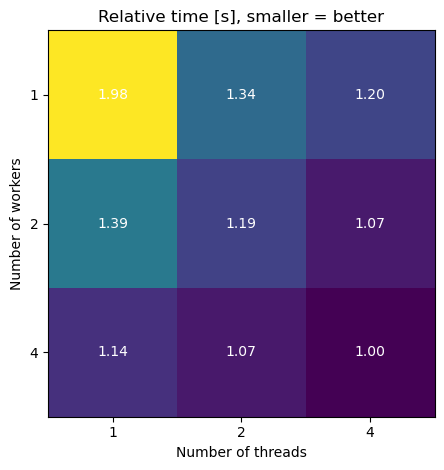

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, '%.2f' %(mean[w,t]/mean.min()),
                       ha="center", va="center", color="w")
ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Relative time [s], smaller = better')
fig.tight_layout()
plt.show()

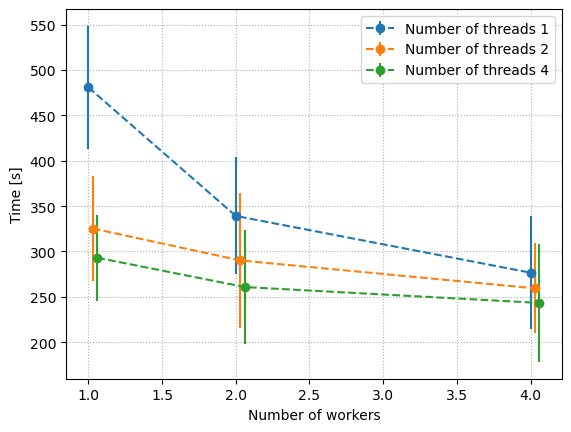

In [ ]:
for k, t in enumerate(threads_list):
    if k == 0:
        plt.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        plt.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        plt.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
plt.grid(linestyle='dotted')
plt.ylabel('Time [s]')
plt.xlabel('Number of workers')
plt.legend()


## Seaborn and Dictionary 

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')

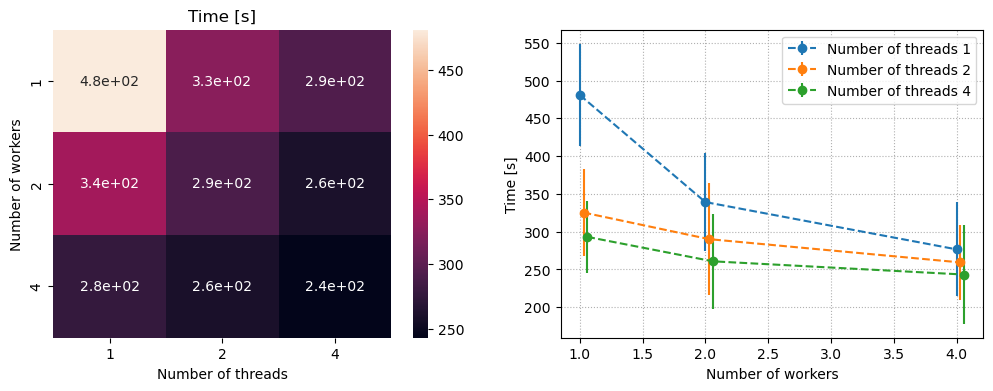

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

df_cm = pd.DataFrame(mean, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 0:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        ax2.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()

### Test to plot sns.heatmap with mean +/- std notation (failed)

In [ ]:
str_mean = np.array(mean, dtype=str).reshape(9)
str_std = np.array(std, dtype=str).reshape(9)

str_array = []
for i in range(len(str_mean)):
    str_array.append(str_mean[i] + '+/-'+ str_std[i])
    
str_array = np.array(str_array)
str_array = str_array.reshape((3,3))
str_array

array([['480.87479009628294+/-67.81540932814285',
        '325.31718435287473+/-57.96199587362794',
        '293.1293914318085+/-47.5261866997072'],
       ['339.1772481918335+/-64.44139219954734',
        '290.127304315567+/-74.31240420156628',
        '260.7830448627472+/-62.883534442304175'],
       ['276.6251482963562+/-62.213373406460136',
        '259.3458333015442+/-49.44453023141172',
        '243.27009415626526+/-65.05455179461765']], dtype='<U38')

ValueError: could not convert string to float: '480.87479009628294+/-67.81540932814285'

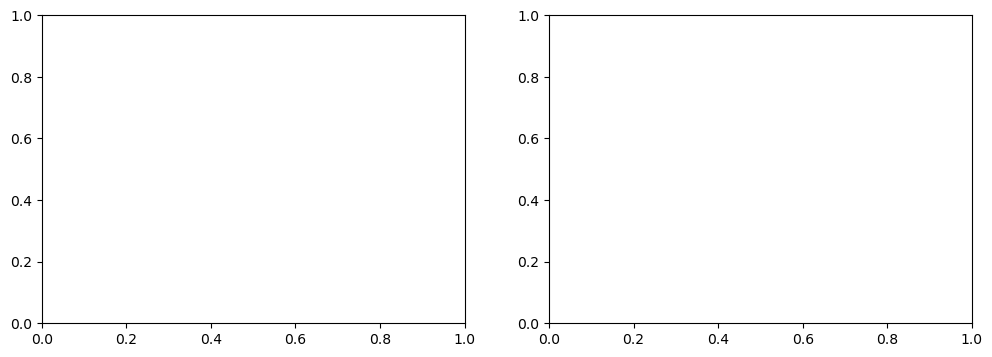

In [ ]:
df_cm = pd.DataFrame(str_array, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 1:
        ax2.errorbar(np.array(workers_list)+0.1, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()


# Benchmar Worker Multiprocessing (poor statistic, no real advantage noticed)

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)
            dask.config.set({'distributed.worker.multiprocessing-method': 'spawn'})

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files/bench_worker_multiprocessing.npy', time_list)

a: 0 	 w: 4 	 t: 4


2023-06-16 08:22:06,766 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,762 - distributed.scheduler - INFO - State start
2023-06-16 08:22:06,772 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,770 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 08:22:07,829 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,827 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35787'
2023-06-16 08:22:07,854 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,852 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36479'
2023-06-16 08:22:07,859 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,856 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35857'
2023-06-16 08:22:07,864 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,860 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33245'
2023-06-16 08:22:08,746 - distributed.deploy.ssh - INFO - 2023-06-16

a: 1 	 w: 4 	 t: 4


2023-06-16 08:25:26,278 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,277 - distributed.scheduler - INFO - State start
2023-06-16 08:25:26,299 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,298 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xmdvrdnz', purging
2023-06-16 08:25:26,397 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,396 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iw1hwwso', purging
2023-06-16 08:25:26,412 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qh8t12kx', purging
2023-06-16 08:25:26,427 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,426 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhl0eg7i', purging
2023-06-16 08:25:26,442 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 4 	 t: 4


2023-06-16 08:28:45,745 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,744 - distributed.scheduler - INFO - State start
2023-06-16 08:28:45,814 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,813 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-po_y4bep', purging
2023-06-16 08:28:46,105 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,104 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hgbd5zvg', purging
2023-06-16 08:28:46,107 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,105 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s2z5dgvi', purging
2023-06-16 08:28:46,111 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,110 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-02ds7uip', purging
2023-06-16 08:28:46,126 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 4 	 t: 4


2023-06-16 08:32:21,079 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,077 - distributed.scheduler - INFO - State start
2023-06-16 08:32:21,134 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,132 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x89xj2f8', purging
2023-06-16 08:32:21,141 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hb98jwx0', purging
2023-06-16 08:32:21,151 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,150 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6mwemqqx', purging
2023-06-16 08:32:21,157 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,156 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yzfbey3q', purging
2023-06-16 08:32:21,163 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 4 	 t: 4


2023-06-16 08:35:44,840 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,837 - distributed.scheduler - INFO - State start
2023-06-16 08:35:44,855 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,853 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zyjv3osx', purging
2023-06-16 08:35:44,883 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,881 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yy1i_bla', purging
2023-06-16 08:35:44,885 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,884 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gwjfjl5s', purging
2023-06-16 08:35:44,889 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,885 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-uxsq9qb7', purging
2023-06-16 08:35:44,894 - distributed.deploy.ssh - INFO - 2023-06

In [ ]:
array = np.load('Bench_files/bench_worker_multiprocessing.npy')
array

array([[[185.79968929]],

       [[187.40345001]],

       [[202.63205862]],

       [[190.16853452]],

       [[199.01239634]]])

In [ ]:
mean, std = np.mean(array), np.std(array)

In [ ]:
print(str(mean) + ' +/- ' + str(std), 'vs', '253 +/- 65')

193.00322575569152 +/- 6.6348843812235545 vs 253 +/- 65


# Benchmark with partitions for output (1, 12, 24)

In [ ]:
def FGpreprocessing_partitions(dir_path: str, n_thread: int, output_column_to_remove: list,
                               evolved_column_to_remove: list, drop_list: list, n_part: int): 
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#    Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove).\
                repartition(npartitions = n_part)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()


    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

In [ ]:
attempt = 10
workers_list = [4]
threads_list = [4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Bench_files_10/Benchmark_divisions_10.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4


2023-06-10 16:30:48,609 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,608 - distributed.scheduler - INFO - State start
2023-06-10 16:30:48,611 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,609 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-za9e9b09', purging
2023-06-10 16:30:48,612 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,610 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s5ksk1s0', purging
2023-06-10 16:30:48,615 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gsazhn76', purging
2023-06-10 16:30:48,616 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x6y027y3', purging
2023-06-10 16:30:48,618 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark divisions

d_1     175.983450
d_2     221.797806
d_12    241.021792
dtype: float64
d_1     13.033073
d_2     22.764691
d_12    22.366035
dtype: float64


Text(0.5, 1.0, 'Benchmark divisions')

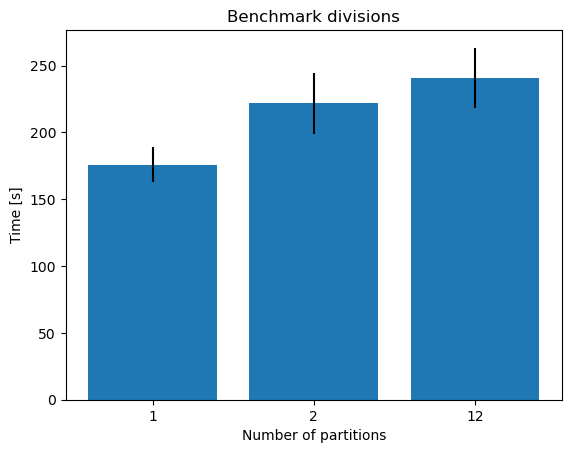

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1, 2, 12] #to br change in the plot in [1,12,24]
array = np.load('Benchmark_divisions.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

array = array.reshape((5, 3))
df = pd.DataFrame(array, columns=['d_1', 'd_2', 'd_12'])
print(df.mean(axis=0))
print(df.std(axis=0))

fig,ax = plt.subplots()
ax.bar(x=['1', '2', '12'], height=df.mean(axis=0), yerr=df.std(axis=0))
ax.set_xlabel('Number of partitions')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark divisions')

# Benchmark number of directory (there is a mistake in the number of directory n, now it has checked n=[0,1,2,3] because of the range(len(number_of_directory))

In [ ]:
attempt = 10
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [1,2,3,4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for n in range(len(number_directory_list)):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', number_directory_list[n])

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:number_directory_list[n]]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, n] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Bench_files_10/Benchmark_directory_10.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 18:52:52,384 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,382 - distributed.scheduler - INFO - State start
2023-06-10 18:52:52,388 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,384 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-frhs3hq1', purging
2023-06-10 18:52:52,389 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,385 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xqpux7kj', purging
2023-06-10 18:52:52,392 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gjb3zpq_', purging
2023-06-10 18:52:52,393 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,387 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3_98msfo', purging
2023-06-10 18:52:52,395 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 18:53:02,321 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,320 - distributed.scheduler - INFO - State start
2023-06-10 18:53:02,324 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,322 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4m4aon0w', purging
2023-06-10 18:53:02,326 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-efwfhmjw', purging
2023-06-10 18:53:02,328 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,326 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-96ahu_ij', purging
2023-06-10 18:53:02,329 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,328 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bwjp2el8', purging
2023-06-10 18:53:02,337 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 18:56:11,511 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,509 - distributed.scheduler - INFO - State start
2023-06-10 18:56:11,513 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,511 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-upjk8ikp', purging
2023-06-10 18:56:11,517 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,517 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0g0uol04', purging
2023-06-10 18:56:11,525 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,524 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mgytvgtc', purging
2023-06-10 18:56:11,530 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,529 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6m5jwu_9', purging
2023-06-10 18:56:11,536 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:01:45,216 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,215 - distributed.scheduler - INFO - State start
2023-06-10 19:01:45,226 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,225 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oabhk91b', purging
2023-06-10 19:01:45,243 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,241 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-cnu6x5qv', purging
2023-06-10 19:01:45,245 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,242 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-exzx9vbk', purging
2023-06-10 19:01:45,247 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,243 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iltqm_j4', purging
2023-06-10 19:01:45,257 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:11:26,462 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,461 - distributed.scheduler - INFO - State start
2023-06-10 19:11:26,481 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,480 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-35ks9ikf', purging
2023-06-10 19:11:26,488 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qtbnv93v', purging
2023-06-10 19:11:26,489 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q9__i13_', purging
2023-06-10 19:11:26,492 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,491 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bqx3w6ss', purging
2023-06-10 19:11:26,500 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:11:33,990 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:33,988 - distributed.scheduler - INFO - State start
2023-06-10 19:11:34,039 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,037 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o3r5755o', purging
2023-06-10 19:11:34,041 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,038 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-g7p32_0x', purging
2023-06-10 19:11:34,042 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-syvvqsd0', purging
2023-06-10 19:11:34,044 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f6tigl2n', purging
2023-06-10 19:11:34,048 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:14:29,888 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,886 - distributed.scheduler - INFO - State start
2023-06-10 19:14:29,896 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,894 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9zdwo6ge', purging
2023-06-10 19:14:29,899 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,895 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0srrtnju', purging
2023-06-10 19:14:29,900 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,896 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zeo7wlfy', purging
2023-06-10 19:14:29,901 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,897 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0nivgn2k', purging
2023-06-10 19:14:29,936 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:20:05,060 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,058 - distributed.scheduler - INFO - State start
2023-06-10 19:20:05,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fe6iluv1', purging
2023-06-10 19:20:05,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mho_gnk2', purging
2023-06-10 19:20:05,074 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a570a1gf', purging
2023-06-10 19:20:05,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ooolqfqd', purging
2023-06-10 19:20:05,084 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:28:22,392 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,390 - distributed.scheduler - INFO - State start
2023-06-10 19:28:22,406 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,405 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4fhwn7bn', purging
2023-06-10 19:28:22,436 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,434 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0x01fcmm', purging
2023-06-10 19:28:22,443 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,442 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ysam46sz', purging
2023-06-10 19:28:22,445 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,443 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fu0ywcjm', purging
2023-06-10 19:28:22,452 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:28:29,824 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,823 - distributed.scheduler - INFO - State start
2023-06-10 19:28:29,830 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-v7443xab', purging
2023-06-10 19:28:29,832 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-701alvl_', purging
2023-06-10 19:28:29,834 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-940bdza_', purging
2023-06-10 19:28:29,841 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-074_ixyc', purging
2023-06-10 19:28:29,842 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:31:22,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,649 - distributed.scheduler - INFO - State start
2023-06-10 19:31:22,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,651 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i5_w6c54', purging
2023-06-10 19:31:22,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rddywufm', purging
2023-06-10 19:31:22,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ejr3929u', purging
2023-06-10 19:31:22,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,653 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6oii9s0b', purging
2023-06-10 19:31:22,717 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:36:23,524 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,523 - distributed.scheduler - INFO - State start
2023-06-10 19:36:23,541 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,539 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fn1itlfa', purging
2023-06-10 19:36:23,599 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8zd7f7n0', purging
2023-06-10 19:36:23,606 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,605 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p6dngpo9', purging
2023-06-10 19:36:23,609 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,607 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oelgh_0v', purging
2023-06-10 19:36:23,615 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:43:41,067 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,065 - distributed.scheduler - INFO - State start
2023-06-10 19:43:41,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,067 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-y_tqv3l1', purging
2023-06-10 19:43:41,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,068 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9463pid_', purging
2023-06-10 19:43:41,076 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2l57wkmw', purging
2023-06-10 19:43:41,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,071 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-re23dx_d', purging
2023-06-10 19:43:41,082 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:43:47,647 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,646 - distributed.scheduler - INFO - State start
2023-06-10 19:43:47,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,654 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8qzhfj2y', purging
2023-06-10 19:43:47,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-do26w1tc', purging
2023-06-10 19:43:47,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-umnsjy0j', purging
2023-06-10 19:43:47,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,656 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bmo9aqd_', purging
2023-06-10 19:43:47,661 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:46:29,943 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,942 - distributed.scheduler - INFO - State start
2023-06-10 19:46:29,951 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,950 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l9u3iy6i', purging
2023-06-10 19:46:29,953 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,951 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f28aueqo', purging
2023-06-10 19:46:29,955 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,952 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1x0uc7p6', purging
2023-06-10 19:46:29,961 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,961 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-e0jehsr8', purging
2023-06-10 19:46:29,967 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:51:19,423 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,421 - distributed.scheduler - INFO - State start
2023-06-10 19:51:19,434 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,432 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mbr8fc27', purging
2023-06-10 19:51:19,446 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,445 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bu4gzx0k', purging
2023-06-10 19:51:19,454 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,453 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-72xvn65t', purging
2023-06-10 19:51:19,456 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,455 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oifzidto', purging
2023-06-10 19:51:19,463 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:58:31,132 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,131 - distributed.scheduler - INFO - State start
2023-06-10 19:58:31,147 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gh6pkn5w', purging
2023-06-10 19:58:31,156 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,155 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rjv1gmj1', purging
2023-06-10 19:58:31,161 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,160 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xk1r_e06', purging
2023-06-10 19:58:31,164 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,162 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lxw95059', purging
2023-06-10 19:58:31,170 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:58:38,643 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,642 - distributed.scheduler - INFO - State start
2023-06-10 19:58:38,648 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,643 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-psm_c8ti', purging
2023-06-10 19:58:38,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,644 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o9cacubu', purging
2023-06-10 19:58:38,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ebrmf1kx', purging
2023-06-10 19:58:38,656 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k03qy6ac', purging
2023-06-10 19:58:38,657 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 20:01:22,537 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,536 - distributed.scheduler - INFO - State start
2023-06-10 20:01:22,541 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,538 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yez1v_lh', purging
2023-06-10 20:01:22,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i6ejebgt', purging
2023-06-10 20:01:22,550 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhcp8kgq', purging
2023-06-10 20:01:22,551 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ydpzswlm', purging
2023-06-10 20:01:22,554 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:06:01,502 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,500 - distributed.scheduler - INFO - State start
2023-06-10 20:06:01,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-n4fl32df', purging
2023-06-10 20:06:01,600 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ew6i70nj', purging
2023-06-10 20:06:01,602 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,600 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_axnxr_m', purging
2023-06-10 20:06:01,605 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,601 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhrs_pc7', purging
2023-06-10 20:06:01,609 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark directory

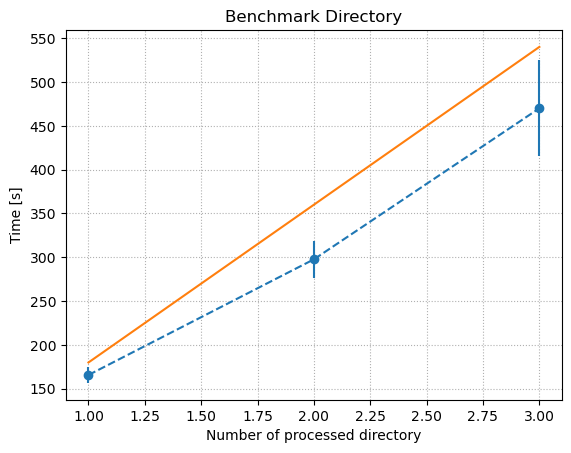

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3]

array = np.load('Bench_files/Benchmark_directory.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')

## Correcting mistake, running the loop for 4 directory 

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for k, n in enumerate(number_directory_list):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', n)

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:n]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, k] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Benchmark_4_directory.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:39:24,169 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,167 - distributed.scheduler - INFO - State start
2023-06-10 20:39:24,174 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,169 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a3aatibd', purging
2023-06-10 20:39:24,341 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,340 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1wukrpef', purging
2023-06-10 20:39:24,356 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,355 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-szhzl7yb', purging
2023-06-10 20:39:24,361 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,360 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h7ft5ym9', purging
2023-06-10 20:39:24,366 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:47:46,960 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,958 - distributed.scheduler - INFO - State start
2023-06-10 20:47:46,980 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,979 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-81u_02f6', purging
2023-06-10 20:47:46,989 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,988 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bhf7fiot', purging
2023-06-10 20:47:46,991 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,990 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pa1kp3zq', purging
2023-06-10 20:47:46,994 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,993 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1fgpptp5', purging
2023-06-10 20:47:47,000 - distributed.deploy.ssh - INFO - 2023-06

## Patch plot

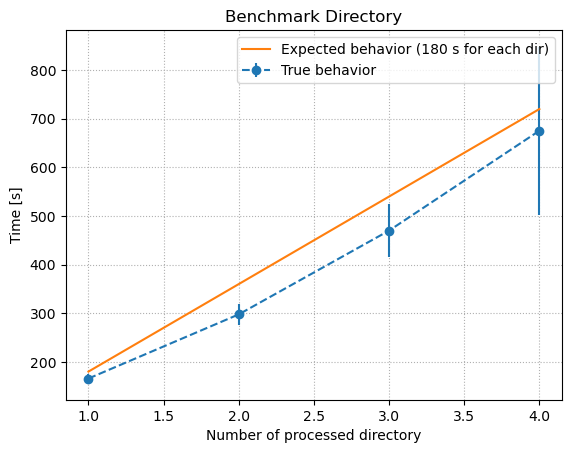

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3,4]

array_1 = np.load('Bench_files/Benchmark_directory.npy')
mean_1 = np.mean(array_1, axis = 0)
std_1 = np.std(array_1, axis = 0)

array_2 = np.load('Bench_files/Benchmark_4_directory.npy')
mean_2 = np.mean(array_2, axis = 0)
std_2 = np.std(array_2, axis = 0)

mean = np.concatenate((mean_1, mean_2), axis=3)
std = np.concatenate((std_1, std_2), axis=3)


fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')
ax.legend()

# Benchmark read_time sync

In [ ]:
cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
client=Client(cluster)

2023-06-10 16:21:37,120 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,119 - distributed.scheduler - INFO - State start
2023-06-10 16:21:37,151 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,150 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-10 16:21:38,165 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,164 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42467'
2023-06-10 16:21:38,176 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,174 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42371'
2023-06-10 16:21:38,186 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,182 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38239'
2023-06-10 16:21:38,199 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,198 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35007'
2023-06-10 16:21:39,074 - distributed.deploy.ssh - INFO - 2023-06-10

In [ ]:
output = dd.read_csv(dir_list[0]+'/0/output_*.csv')
output.columns

Index(['ID', 'name', 'Mass_0', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0', 'RCO_0',
       'Luminosity_0', 'Temperature_0', 'Lambda_0', 'Phase_0', 'PhaseBSE_0',
       'RemnantType_0', 'Zams_0', 'Mass_1', 'MHE_1', 'MCO_1', 'Radius_1',
       'RHE_1', 'RCO_1', 'Luminosity_1', 'Temperature_1', 'Lambda_1',
       'Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Zams_1', 'Semimajor',
       'Eccentricity', 'GWtime', 'BWorldtime', 'BEvent'],
      dtype='object')

In [ ]:
%%time
mean_output = output['name'].count()
mean = dask.compute(mean_output)

CPU times: user 662 ms, sys: 120 ms, total: 782 ms
Wall time: 3min 42s


# Benchmark Grid search (Thread, workers, partitions)

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Benchmark_GridSearch.npy', time_list)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

import dask.dataframe as dd
import dask.array as da
# import dask.bag as db
import dask
from dask.distributed import Client, SSHCluster
import dask.distributed

# import hvplot.dask

In [ ]:
import glob
dir_path = '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_*'
dir_list = glob.glob(dir_path)
print(len(dir_list))

60


In [ ]:
output_column_to_remove = ['ID', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0','RCO_0', 'Luminosity_0', 'Temperature_0', 'Lambda_0',
                               'Phase_0', 'PhaseBSE_0', 'Zams_0', 'MHE_1', 'MCO_1','Radius_1', 'RHE_1', 'RCO_1', 
                               'Luminosity_1', 'Temperature_1','Lambda_1', 'Phase_1', 'PhaseBSE_1', 'Zams_1']
    
evolved_column_to_remove = ['#ID', 'spin_0', 'Tstart_0', 'spin_1', 'Tstart_1', 'Tend', 'Dtout', 'Seed']
drop_list = ['RemnantType_0',  'RemnantType_1']

In [ ]:
def FGpreprocessing(dir_path: str, n_thread: int, output_column_to_remove: list, evolved_column_to_remove: list, drop_list: list):
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#     Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()

    ##################################

    

    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

# Benchmark Workers Threads

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Benchmark_Workers_Threads.npy', time_list)

a: 0 	 w: 1 	 t: 1


2023-06-09 17:04:22,119 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:22,117 - distributed.scheduler - INFO - State start
2023-06-09 17:04:22,127 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:22,119 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-j244lalc', purging
2023-06-09 17:04:22,140 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:22,138 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:04:23,180 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:23,178 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45873'
2023-06-09 17:04:24,089 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:24,088 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:34709
2023-06-09 17:04:26,321 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:26,313 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:45773'
2023-06-09 17:04:26,724 - dis

a: 0 	 w: 1 	 t: 2


2023-06-09 17:12:52,993 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:52,992 - distributed.scheduler - INFO - State start
2023-06-09 17:12:52,996 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:52,993 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l9x6js6p', purging
2023-06-09 17:12:53,028 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:53,027 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:12:54,004 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:54,003 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43361'
2023-06-09 17:12:54,906 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:54,905 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44101
2023-06-09 17:12:57,004 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:56,999 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:37585'
2023-06-09 17:12:57,373 - dis

a: 0 	 w: 1 	 t: 4


2023-06-09 17:18:14,874 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:14,872 - distributed.scheduler - INFO - State start
2023-06-09 17:18:14,880 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:14,879 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ac6m7pfy', purging
2023-06-09 17:18:14,886 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:14,884 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:18:15,873 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:15,871 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36807'
2023-06-09 17:18:16,766 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:16,764 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:37025
2023-06-09 17:18:18,746 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:18,742 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:40833'
2023-06-09 17:18:18,908 - dis

a: 0 	 w: 2 	 t: 1


2023-06-09 17:24:30,698 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:30,696 - distributed.scheduler - INFO - State start
2023-06-09 17:24:30,701 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:30,698 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-j5iqtbyb', purging
2023-06-09 17:24:30,708 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:30,706 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:24:31,716 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:31,715 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38509'
2023-06-09 17:24:31,748 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:31,747 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41563'
2023-06-09 17:24:32,546 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:32,539 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:32967
2023-06-09 17:24:32,547 - di

a: 0 	 w: 2 	 t: 2


2023-06-09 17:31:06,160 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,158 - distributed.scheduler - INFO - State start
2023-06-09 17:31:06,170 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,169 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ztrbmpux', purging
2023-06-09 17:31:06,197 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,196 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iiuuq3lo', purging
2023-06-09 17:31:06,207 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,206 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:31:07,195 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:07,194 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38015'
2023-06-09 17:31:07,213 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:07,211 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 2 	 t: 4


2023-06-09 17:38:02,807 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,805 - distributed.scheduler - INFO - State start
2023-06-09 17:38:02,816 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,807 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_lhm6x02', purging
2023-06-09 17:38:02,855 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,854 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2o_rdx4t', purging
2023-06-09 17:38:02,866 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,865 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:38:03,859 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:03,858 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45899'
2023-06-09 17:38:03,879 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:03,877 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 4 	 t: 1


2023-06-09 17:43:49,804 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:49,803 - distributed.scheduler - INFO - State start
2023-06-09 17:43:49,879 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:49,878 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x19sh8ks', purging
2023-06-09 17:43:49,921 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:49,920 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-sr7fjs2n', purging
2023-06-09 17:43:50,046 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:50,044 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:43:51,081 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:51,080 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45079'
2023-06-09 17:43:51,097 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:51,096 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 4 	 t: 2


2023-06-09 17:48:10,139 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,137 - distributed.scheduler - INFO - State start
2023-06-09 17:48:10,146 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,144 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-goxknqve', purging
2023-06-09 17:48:10,148 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hqehm5vr', purging
2023-06-09 17:48:10,149 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,146 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-b70bl5k3', purging
2023-06-09 17:48:10,152 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,146 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9wsehqbf', purging
2023-06-09 17:48:10,155 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 w: 4 	 t: 4


2023-06-09 17:52:10,886 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,884 - distributed.scheduler - INFO - State start
2023-06-09 17:52:10,889 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,886 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dqnfpr6r', purging
2023-06-09 17:52:10,898 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,897 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s9k25zwx', purging
2023-06-09 17:52:10,904 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,903 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3oqkrspz', purging
2023-06-09 17:52:10,907 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,904 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rb3y1o6h', purging
2023-06-09 17:52:10,912 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 w: 1 	 t: 1


2023-06-09 17:55:46,190 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,188 - distributed.scheduler - INFO - State start
2023-06-09 17:55:46,204 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,202 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8dppa8am', purging
2023-06-09 17:55:46,260 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,259 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0mabqn8c', purging
2023-06-09 17:55:46,265 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,263 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qy75209k', purging
2023-06-09 17:55:46,271 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,270 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3t17ditj', purging
2023-06-09 17:55:46,277 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 w: 1 	 t: 2


2023-06-09 18:03:07,586 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:07,584 - distributed.scheduler - INFO - State start
2023-06-09 18:03:07,590 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:07,586 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-35hbo06x', purging
2023-06-09 18:03:07,599 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:07,598 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:03:08,575 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:08,573 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39161'
2023-06-09 18:03:09,417 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:09,415 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:36107
2023-06-09 18:03:10,209 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:10,206 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:46651'
2023-06-09 18:03:10,556 - dis

a: 1 	 w: 1 	 t: 4


2023-06-09 18:08:02,056 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:02,054 - distributed.scheduler - INFO - State start
2023-06-09 18:08:02,063 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:02,062 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p6wf0k9y', purging
2023-06-09 18:08:02,069 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:02,068 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:08:03,081 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:03,080 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36155'
2023-06-09 18:08:04,455 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:04,453 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:44571'
2023-06-09 18:08:04,700 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:04,699 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44961
2023-06-09 18:08:04,790 - dis

a: 1 	 w: 2 	 t: 1


2023-06-09 18:12:41,550 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:41,549 - distributed.scheduler - INFO - State start
2023-06-09 18:12:41,553 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:41,551 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a_9n7puw', purging
2023-06-09 18:12:41,565 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:41,564 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:12:42,547 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:42,545 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39429'
2023-06-09 18:12:42,566 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:42,564 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43507'
2023-06-09 18:12:43,334 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:43,332 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:32881
2023-06-09 18:12:43,335 - di

a: 1 	 w: 2 	 t: 2


2023-06-09 18:18:20,826 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,825 - distributed.scheduler - INFO - State start
2023-06-09 18:18:20,844 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,842 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xrjdgrtj', purging
2023-06-09 18:18:20,851 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,850 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xubklxx4', purging
2023-06-09 18:18:20,863 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,862 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:18:21,763 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:21,762 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41253'
2023-06-09 18:18:21,775 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:21,773 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 1 	 w: 2 	 t: 4


2023-06-09 18:22:41,200 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,199 - distributed.scheduler - INFO - State start
2023-06-09 18:22:41,205 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,204 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0pwsr8pt', purging
2023-06-09 18:22:41,212 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,212 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gj2joxsu', purging
2023-06-09 18:22:41,218 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,217 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:22:42,114 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:42,113 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34177'
2023-06-09 18:22:42,130 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:42,129 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 1 	 w: 4 	 t: 1


2023-06-09 18:26:55,106 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,105 - distributed.scheduler - INFO - State start
2023-06-09 18:26:55,119 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,118 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-jyf_8ijp', purging
2023-06-09 18:26:55,121 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,118 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q4_n1r8s', purging
2023-06-09 18:26:55,174 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,173 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:26:56,203 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:56,202 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38459'
2023-06-09 18:26:56,272 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:56,271 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 1 	 w: 4 	 t: 4


2023-06-09 18:38:10,249 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,246 - distributed.scheduler - INFO - State start
2023-06-09 18:38:10,258 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,257 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8w9j7x4p', purging
2023-06-09 18:38:10,264 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,263 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0w09meqk', purging
2023-06-09 18:38:10,267 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,264 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bi362lu5', purging
2023-06-09 18:38:10,268 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,264 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l5whf4g2', purging
2023-06-09 18:38:10,271 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 1 	 t: 1


2023-06-09 18:44:30,086 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,084 - distributed.scheduler - INFO - State start
2023-06-09 18:44:30,091 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,090 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6mdjgmxw', purging
2023-06-09 18:44:30,114 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,112 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qp1d4wv5', purging
2023-06-09 18:44:30,120 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,119 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zitfrvy8', purging
2023-06-09 18:44:30,123 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,122 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l019y3xk', purging
2023-06-09 18:44:30,131 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 1 	 t: 2


2023-06-09 18:54:22,457 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:22,455 - distributed.scheduler - INFO - State start
2023-06-09 18:54:22,465 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:22,463 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8ew3ay7g', purging
2023-06-09 18:54:22,490 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:22,489 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:54:23,380 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:23,379 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:44063'
2023-06-09 18:54:24,202 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:24,200 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:46671
2023-06-09 18:54:25,937 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:25,934 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.220:35039'
2023-06-09 18:54:25,990 - di

a: 2 	 w: 1 	 t: 4


2023-06-09 19:01:24,653 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:24,651 - distributed.scheduler - INFO - State start
2023-06-09 19:01:24,657 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:24,653 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-vi22aita', purging
2023-06-09 19:01:24,660 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:24,659 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:01:25,618 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:25,617 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37617'
2023-06-09 19:01:26,448 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:26,447 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44673
2023-06-09 19:01:27,739 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:27,737 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.31:39529'
2023-06-09 19:01:27,910 - dis

a: 2 	 w: 2 	 t: 1


2023-06-09 19:06:24,020 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:24,019 - distributed.scheduler - INFO - State start
2023-06-09 19:06:24,037 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:24,035 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xyy8sm6l', purging
2023-06-09 19:06:24,042 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:24,041 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:06:25,051 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:25,048 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45207'
2023-06-09 19:06:25,087 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:25,086 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33031'
2023-06-09 19:06:25,907 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:25,903 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:42935
2023-06-09 19:06:25,909 - di

a: 2 	 w: 2 	 t: 2


2023-06-09 19:13:17,881 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,879 - distributed.scheduler - INFO - State start
2023-06-09 19:13:17,887 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,885 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c7dchzzz', purging
2023-06-09 19:13:17,890 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,887 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k0oyssc2', purging
2023-06-09 19:13:17,895 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,894 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:13:18,868 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:18,867 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35231'
2023-06-09 19:13:18,895 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:18,894 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 2 	 w: 2 	 t: 4


2023-06-09 19:19:07,585 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,583 - distributed.scheduler - INFO - State start
2023-06-09 19:19:07,595 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,593 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8_1u06jz', purging
2023-06-09 19:19:07,602 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,601 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1wwrewcj', purging
2023-06-09 19:19:07,611 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,610 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:19:08,549 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:08,547 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:46117'
2023-06-09 19:19:08,570 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:08,569 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 2 	 w: 4 	 t: 1


2023-06-09 19:24:35,029 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,028 - distributed.scheduler - INFO - State start
2023-06-09 19:24:35,041 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,040 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7jj352yt', purging
2023-06-09 19:24:35,045 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,041 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c4h12pik', purging
2023-06-09 19:24:35,055 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,054 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:24:36,047 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:36,045 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34567'
2023-06-09 19:24:36,067 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:36,066 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 2 	 w: 4 	 t: 2


2023-06-09 19:30:10,136 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,134 - distributed.scheduler - INFO - State start
2023-06-09 19:30:10,141 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iefdgk7j', purging
2023-06-09 19:30:10,148 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,148 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pu8l6vsg', purging
2023-06-09 19:30:10,154 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,153 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9w73haqe', purging
2023-06-09 19:30:10,158 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,155 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h7a7_ogt', purging
2023-06-09 19:30:10,163 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 4 	 t: 4


2023-06-09 19:34:34,797 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,795 - distributed.scheduler - INFO - State start
2023-06-09 19:34:34,805 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,804 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p5bhst7c', purging
2023-06-09 19:34:34,827 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3mpzsk_k', purging
2023-06-09 19:34:34,829 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,827 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zvbpxd3x', purging
2023-06-09 19:34:34,831 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,827 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6hxp8u50', purging
2023-06-09 19:34:34,836 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 1 	 t: 1


2023-06-09 19:38:53,204 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,203 - distributed.scheduler - INFO - State start
2023-06-09 19:38:53,214 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,213 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-jk_zkoss', purging
2023-06-09 19:38:53,250 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7y5aw84u', purging
2023-06-09 19:38:53,253 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,251 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7ha8ne3u', purging
2023-06-09 19:38:53,255 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,255 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-j1tvulup', purging
2023-06-09 19:38:53,267 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 1 	 t: 2


2023-06-09 19:47:36,603 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:36,601 - distributed.scheduler - INFO - State start
2023-06-09 19:47:36,615 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:36,614 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ajad0aye', purging
2023-06-09 19:47:36,630 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:36,629 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:47:37,562 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:37,561 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:40549'
2023-06-09 19:47:38,895 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:38,893 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:36057
2023-06-09 19:47:39,659 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:39,654 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:42295'
2023-06-09 19:47:39,788 - dis

a: 3 	 w: 1 	 t: 4


2023-06-09 19:53:56,834 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:56,833 - distributed.scheduler - INFO - State start
2023-06-09 19:53:56,837 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:56,835 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xvefl716', purging
2023-06-09 19:53:56,840 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:56,840 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:53:57,794 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:57,792 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34787'
2023-06-09 19:53:58,582 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:58,581 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:40407
2023-06-09 19:53:59,673 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:59,669 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:42289'
2023-06-09 19:53:59,922 - dis

a: 3 	 w: 2 	 t: 1


2023-06-09 19:59:29,474 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:29,472 - distributed.scheduler - INFO - State start
2023-06-09 19:59:29,484 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:29,482 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-atqjgg1c', purging
2023-06-09 19:59:29,494 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:29,493 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:59:30,495 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:30,493 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41479'
2023-06-09 19:59:30,507 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:30,505 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35911'
2023-06-09 19:59:31,290 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:31,289 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:33051
2023-06-09 19:59:31,298 - di

a: 3 	 w: 2 	 t: 2


2023-06-09 20:05:41,098 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,097 - distributed.scheduler - INFO - State start
2023-06-09 20:05:41,122 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,120 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rbg8kgnu', purging
2023-06-09 20:05:41,128 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,127 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-nd98u98q', purging
2023-06-09 20:05:41,133 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,133 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:05:42,113 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:42,112 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33289'
2023-06-09 20:05:42,121 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:42,120 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 3 	 w: 2 	 t: 4


2023-06-09 20:10:25,418 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,416 - distributed.scheduler - INFO - State start
2023-06-09 20:10:25,431 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,429 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mzytht2u', purging
2023-06-09 20:10:25,439 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,438 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qzttkr19', purging
2023-06-09 20:10:25,456 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,455 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:10:26,374 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:26,373 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35469'
2023-06-09 20:10:26,388 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:26,387 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 3 	 w: 4 	 t: 1


2023-06-09 20:14:46,212 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,211 - distributed.scheduler - INFO - State start
2023-06-09 20:14:46,215 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,213 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-kg97ie4z', purging
2023-06-09 20:14:46,217 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,213 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-by488iia', purging
2023-06-09 20:14:46,224 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,223 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:14:47,164 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:47,162 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38441'
2023-06-09 20:14:47,175 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:47,174 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 3 	 w: 4 	 t: 2


2023-06-09 20:20:36,925 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,923 - distributed.scheduler - INFO - State start
2023-06-09 20:20:36,936 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,935 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p2yu8dlp', purging
2023-06-09 20:20:36,947 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,946 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ctni5rje', purging
2023-06-09 20:20:36,948 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,946 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c_kt9pez', purging
2023-06-09 20:20:36,950 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,948 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-w6w1_poy', purging
2023-06-09 20:20:36,954 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 4 	 t: 4


2023-06-09 20:25:20,609 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,608 - distributed.scheduler - INFO - State start
2023-06-09 20:25:20,627 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,625 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2779cfu0', purging
2023-06-09 20:25:20,640 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,639 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l4fptxso', purging
2023-06-09 20:25:20,645 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,644 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-eki9vshj', purging
2023-06-09 20:25:20,646 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,646 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-w986_6c7', purging
2023-06-09 20:25:20,653 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 1 	 t: 1


2023-06-09 20:28:44,285 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,284 - distributed.scheduler - INFO - State start
2023-06-09 20:28:44,307 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,306 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6sld8nb3', purging
2023-06-09 20:28:44,367 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,366 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dxbn8zht', purging
2023-06-09 20:28:44,377 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,376 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3y7lli3_', purging
2023-06-09 20:28:44,383 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,382 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9m4mfluw', purging
2023-06-09 20:28:44,394 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 1 	 t: 2


2023-06-09 20:35:18,921 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:18,918 - distributed.scheduler - INFO - State start
2023-06-09 20:35:18,926 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:18,920 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-09ijbxmx', purging
2023-06-09 20:35:18,929 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:18,926 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:35:19,934 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:19,932 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36089'
2023-06-09 20:35:20,752 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:20,748 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44779
2023-06-09 20:35:21,578 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:21,574 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:45949'
2023-06-09 20:35:21,947 - dis

a: 4 	 w: 1 	 t: 4


2023-06-09 20:39:39,563 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:39,561 - distributed.scheduler - INFO - State start
2023-06-09 20:39:39,601 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:39,600 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qvzuohs_', purging
2023-06-09 20:39:39,606 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:39,606 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:39:40,458 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:40,456 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37851'
2023-06-09 20:39:41,195 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:41,193 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:45149
2023-06-09 20:39:42,290 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:42,286 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:41789'
2023-06-09 20:39:42,649 - dis

a: 4 	 w: 2 	 t: 1


2023-06-09 20:43:32,311 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:32,309 - distributed.scheduler - INFO - State start
2023-06-09 20:43:32,350 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:32,348 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lh9yd33b', purging
2023-06-09 20:43:32,365 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:32,363 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:43:33,300 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:33,299 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34585'
2023-06-09 20:43:33,312 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:33,311 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34339'
2023-06-09 20:43:34,041 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:34,034 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:40143
2023-06-09 20:43:34,042 - di

a: 4 	 w: 2 	 t: 2


2023-06-09 20:47:22,247 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,246 - distributed.scheduler - INFO - State start
2023-06-09 20:47:22,253 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,252 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lx9cl9q5', purging
2023-06-09 20:47:22,283 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,282 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-berr1zme', purging
2023-06-09 20:47:22,288 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,288 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:47:23,212 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:23,211 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43077'
2023-06-09 20:47:23,225 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:23,224 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 4 	 w: 2 	 t: 4


2023-06-09 20:50:40,666 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,665 - distributed.scheduler - INFO - State start
2023-06-09 20:50:40,696 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,695 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dui5_lh1', purging
2023-06-09 20:50:40,704 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,703 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-n8c29rd3', purging
2023-06-09 20:50:40,710 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,709 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:50:41,597 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:41,595 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41151'
2023-06-09 20:50:41,607 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:41,606 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 4 	 w: 4 	 t: 1


2023-06-09 20:53:27,695 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,693 - distributed.scheduler - INFO - State start
2023-06-09 20:53:27,698 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,695 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ur5sk6_w', purging
2023-06-09 20:53:27,745 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,743 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-tplpgv9l', purging
2023-06-09 20:53:27,754 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,753 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:53:28,721 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:28,720 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33195'
2023-06-09 20:53:28,734 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:28,733 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 4 	 w: 4 	 t: 2


2023-06-09 20:56:25,962 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,960 - distributed.scheduler - INFO - State start
2023-06-09 20:56:25,970 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h6zk0ds_', purging
2023-06-09 20:56:25,972 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k9hulyw_', purging
2023-06-09 20:56:25,973 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,970 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0340b2ko', purging
2023-06-09 20:56:25,974 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,970 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mb3csmsu', purging
2023-06-09 20:56:26,023 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 4 	 t: 4


2023-06-09 21:00:00,432 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,430 - distributed.scheduler - INFO - State start
2023-06-09 21:00:00,452 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,450 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q4gt_rvz', purging
2023-06-09 21:00:00,465 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,464 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-swbadx_f', purging
2023-06-09 21:00:00,470 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,470 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c3d_9xbb', purging
2023-06-09 21:00:00,472 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,470 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-58x6hfaf', purging
2023-06-09 21:00:00,478 - distributed.deploy.ssh - INFO - 2023-06

# Plot

 ## Matplotlib 

In [ ]:
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')
array

array([[[496.18939042, 309.44374251, 363.26255941],
        [383.50346351, 403.58574152, 335.96760678],
        [249.42443776, 225.85286474, 201.97225642]],

       [[430.55225253, 284.76588345, 269.20183468],
        [327.67098856, 248.67283058, 244.65126681],
        [303.31334281, 346.56437111, 368.19598842]],

       [[580.6985929 , 411.72727776, 288.80423403],
        [403.49360991, 337.66984129, 315.66719437],
        [323.27917314, 249.95861268, 245.46395135]],

       [[512.35118294, 369.4232645 , 321.72102141],
        [360.65168834, 272.86523509, 250.48180246],
        [339.16766191, 271.98966718, 191.38780403]],

       [[384.58253169, 251.22575355, 222.65730762],
        [220.56649065, 187.8428731 , 157.14735389],
        [167.94112587, 202.3636508 , 209.33047056]]])

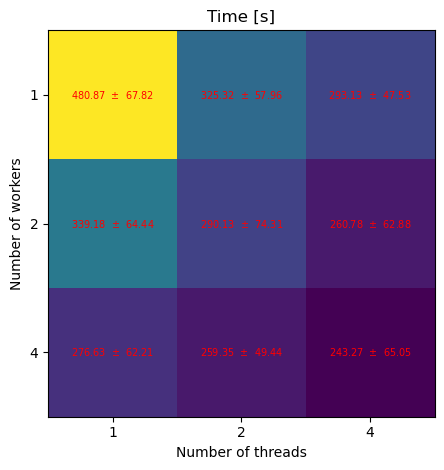

<Figure size 640x480 with 0 Axes>

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, r'%.2f  $\pm$  %.2f' % (mean[w,t], std[w,t]),
                       ha="center", va="center", color="red", fontsize=7)

ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Time [s]')
fig.tight_layout()
plt.figure(figsize=(8, 6), dpi=80)

plt.show()

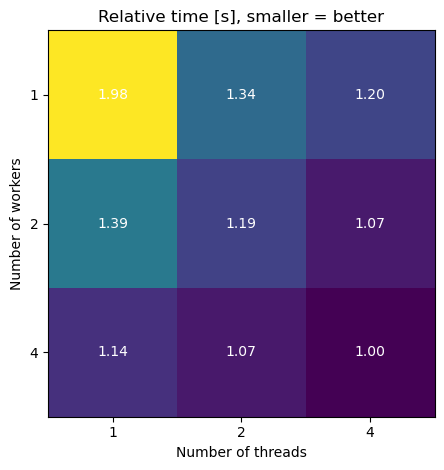

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, '%.2f' %(mean[w,t]/mean.min()),
                       ha="center", va="center", color="w")
ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Relative time [s], smaller = better')
fig.tight_layout()
plt.show()

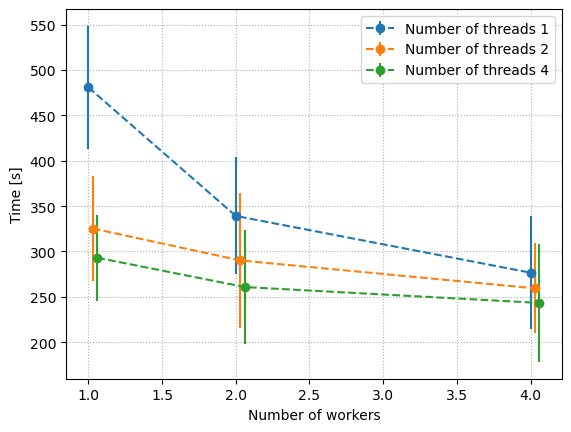

In [ ]:
for k, t in enumerate(threads_list):
    if k == 0:
        plt.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        plt.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        plt.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
plt.grid(linestyle='dotted')
plt.ylabel('Time [s]')
plt.xlabel('Number of workers')
plt.legend()


# Seaborn and Dictionary 

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')

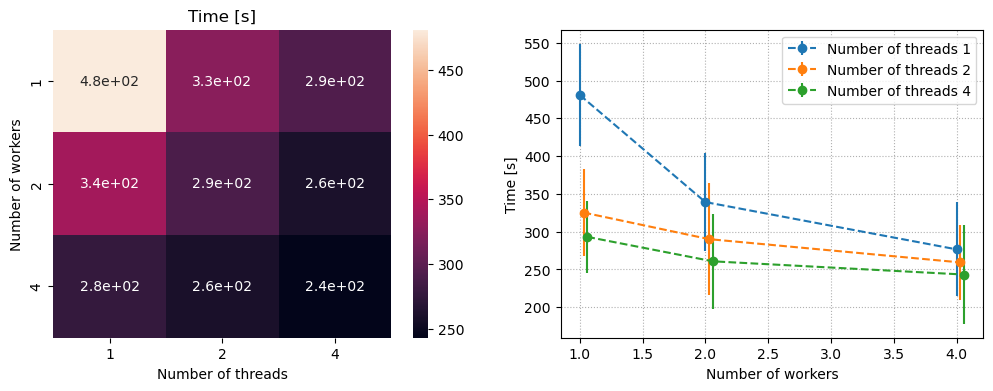

In [ ]:
mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

df_cm = pd.DataFrame(mean, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 0:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        ax2.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()

### Test to plot sns.heatmap with mean +/- std notation (failed)

In [ ]:
str_mean = np.array(mean, dtype=str).reshape(9)
str_std = np.array(std, dtype=str).reshape(9)

str_array = []
for i in range(len(str_mean)):
    str_array.append(str_mean[i] + '+/-'+ str_std[i])
    
str_array = np.array(str_array)
str_array = str_array.reshape((3,3))
str_array

array([['480.87479009628294+/-67.81540932814285',
        '325.31718435287473+/-57.96199587362794',
        '293.1293914318085+/-47.5261866997072'],
       ['339.1772481918335+/-64.44139219954734',
        '290.127304315567+/-74.31240420156628',
        '260.7830448627472+/-62.883534442304175'],
       ['276.6251482963562+/-62.213373406460136',
        '259.3458333015442+/-49.44453023141172',
        '243.27009415626526+/-65.05455179461765']], dtype='<U38')

ValueError: could not convert string to float: '480.87479009628294+/-67.81540932814285'

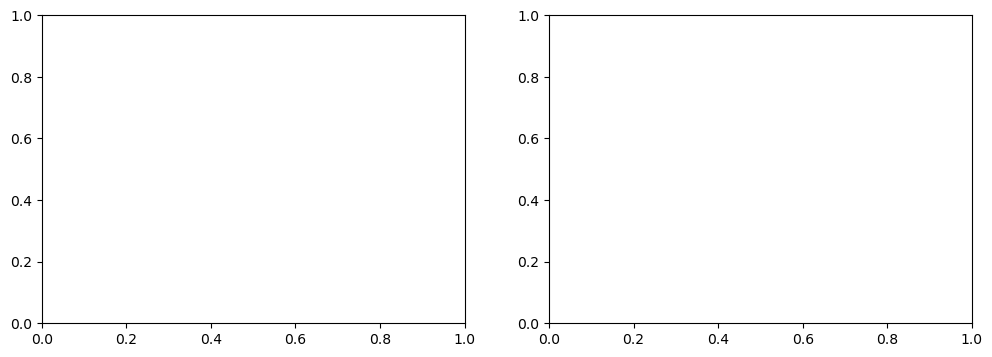

In [ ]:
df_cm = pd.DataFrame(str_array, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 1:
        ax2.errorbar(np.array(workers_list)+0.1, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()


# Benchmar Worker Multiprocessing (poor statistic, no real advantage noticed)

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)
            dask.config.set({'distributed.worker.multiprocessing-method': 'spawn'})

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files/bench_worker_multiprocessing.npy', time_list)

a: 0 	 w: 4 	 t: 4


2023-06-16 08:22:06,766 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,762 - distributed.scheduler - INFO - State start
2023-06-16 08:22:06,772 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,770 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 08:22:07,829 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,827 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35787'
2023-06-16 08:22:07,854 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,852 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36479'
2023-06-16 08:22:07,859 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,856 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35857'
2023-06-16 08:22:07,864 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,860 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33245'
2023-06-16 08:22:08,746 - distributed.deploy.ssh - INFO - 2023-06-16

a: 1 	 w: 4 	 t: 4


2023-06-16 08:25:26,278 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,277 - distributed.scheduler - INFO - State start
2023-06-16 08:25:26,299 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,298 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xmdvrdnz', purging
2023-06-16 08:25:26,397 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,396 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iw1hwwso', purging
2023-06-16 08:25:26,412 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qh8t12kx', purging
2023-06-16 08:25:26,427 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,426 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhl0eg7i', purging
2023-06-16 08:25:26,442 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 4 	 t: 4


2023-06-16 08:28:45,745 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,744 - distributed.scheduler - INFO - State start
2023-06-16 08:28:45,814 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,813 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-po_y4bep', purging
2023-06-16 08:28:46,105 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,104 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hgbd5zvg', purging
2023-06-16 08:28:46,107 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,105 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s2z5dgvi', purging
2023-06-16 08:28:46,111 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,110 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-02ds7uip', purging
2023-06-16 08:28:46,126 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 4 	 t: 4


2023-06-16 08:32:21,079 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,077 - distributed.scheduler - INFO - State start
2023-06-16 08:32:21,134 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,132 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x89xj2f8', purging
2023-06-16 08:32:21,141 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hb98jwx0', purging
2023-06-16 08:32:21,151 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,150 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6mwemqqx', purging
2023-06-16 08:32:21,157 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,156 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yzfbey3q', purging
2023-06-16 08:32:21,163 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 4 	 t: 4


2023-06-16 08:35:44,840 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,837 - distributed.scheduler - INFO - State start
2023-06-16 08:35:44,855 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,853 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zyjv3osx', purging
2023-06-16 08:35:44,883 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,881 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yy1i_bla', purging
2023-06-16 08:35:44,885 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,884 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gwjfjl5s', purging
2023-06-16 08:35:44,889 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,885 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-uxsq9qb7', purging
2023-06-16 08:35:44,894 - distributed.deploy.ssh - INFO - 2023-06

In [ ]:
array = np.load('Bench_files/bench_worker_multiprocessing.npy')
array

array([[[185.79968929]],

       [[187.40345001]],

       [[202.63205862]],

       [[190.16853452]],

       [[199.01239634]]])

In [ ]:
mean, std = np.mean(array), np.std(array)

In [ ]:
print(str(mean) + ' +/- ' + str(std), 'vs', '253 +/- 65')

193.00322575569152 +/- 6.6348843812235545 vs 253 +/- 65


# Benchmark with partitions for output (1, 12, 24)

In [ ]:
def FGpreprocessing_partitions(dir_path: str, n_thread: int, output_column_to_remove: list,
                               evolved_column_to_remove: list, drop_list: list, n_part: int): 
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#    Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove).\
                repartition(npartitions = n_part)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()


    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Benchmark_divisions.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4


2023-06-10 16:30:48,609 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,608 - distributed.scheduler - INFO - State start
2023-06-10 16:30:48,611 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,609 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-za9e9b09', purging
2023-06-10 16:30:48,612 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,610 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s5ksk1s0', purging
2023-06-10 16:30:48,615 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gsazhn76', purging
2023-06-10 16:30:48,616 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x6y027y3', purging
2023-06-10 16:30:48,618 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark divisions

d_1     175.983450
d_2     221.797806
d_12    241.021792
dtype: float64
d_1     13.033073
d_2     22.764691
d_12    22.366035
dtype: float64


Text(0.5, 1.0, 'Benchmark divisions')

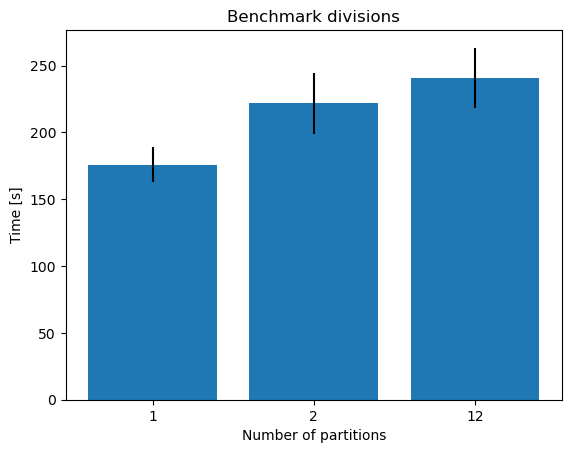

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1, 2, 12] #to br change in the plot in [1,12,24]
array = np.load('Benchmark_divisions.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

array = array.reshape((5, 3))
df = pd.DataFrame(array, columns=['d_1', 'd_2', 'd_12'])
print(df.mean(axis=0))
print(df.std(axis=0))

fig,ax = plt.subplots()
ax.bar(x=['1', '2', '12'], height=df.mean(axis=0), yerr=df.std(axis=0))
ax.set_xlabel('Number of partitions')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark divisions')

# Benchmark number of directory (there is a mistake in the number of directory n, now it has checked n=[0,1,2,3] because of the range(len(number_of_directory))

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [1,2,3,4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for n in range(len(number_directory_list)):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', number_directory_list[n])

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:n]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, n] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Benchmark_directory.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 18:52:52,384 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,382 - distributed.scheduler - INFO - State start
2023-06-10 18:52:52,388 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,384 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-frhs3hq1', purging
2023-06-10 18:52:52,389 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,385 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xqpux7kj', purging
2023-06-10 18:52:52,392 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gjb3zpq_', purging
2023-06-10 18:52:52,393 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,387 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3_98msfo', purging
2023-06-10 18:52:52,395 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 18:53:02,321 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,320 - distributed.scheduler - INFO - State start
2023-06-10 18:53:02,324 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,322 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4m4aon0w', purging
2023-06-10 18:53:02,326 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-efwfhmjw', purging
2023-06-10 18:53:02,328 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,326 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-96ahu_ij', purging
2023-06-10 18:53:02,329 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,328 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bwjp2el8', purging
2023-06-10 18:53:02,337 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 18:56:11,511 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,509 - distributed.scheduler - INFO - State start
2023-06-10 18:56:11,513 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,511 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-upjk8ikp', purging
2023-06-10 18:56:11,517 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,517 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0g0uol04', purging
2023-06-10 18:56:11,525 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,524 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mgytvgtc', purging
2023-06-10 18:56:11,530 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,529 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6m5jwu_9', purging
2023-06-10 18:56:11,536 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:01:45,216 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,215 - distributed.scheduler - INFO - State start
2023-06-10 19:01:45,226 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,225 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oabhk91b', purging
2023-06-10 19:01:45,243 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,241 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-cnu6x5qv', purging
2023-06-10 19:01:45,245 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,242 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-exzx9vbk', purging
2023-06-10 19:01:45,247 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,243 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iltqm_j4', purging
2023-06-10 19:01:45,257 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:11:26,462 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,461 - distributed.scheduler - INFO - State start
2023-06-10 19:11:26,481 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,480 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-35ks9ikf', purging
2023-06-10 19:11:26,488 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qtbnv93v', purging
2023-06-10 19:11:26,489 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q9__i13_', purging
2023-06-10 19:11:26,492 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,491 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bqx3w6ss', purging
2023-06-10 19:11:26,500 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:11:33,990 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:33,988 - distributed.scheduler - INFO - State start
2023-06-10 19:11:34,039 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,037 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o3r5755o', purging
2023-06-10 19:11:34,041 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,038 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-g7p32_0x', purging
2023-06-10 19:11:34,042 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-syvvqsd0', purging
2023-06-10 19:11:34,044 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f6tigl2n', purging
2023-06-10 19:11:34,048 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:14:29,888 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,886 - distributed.scheduler - INFO - State start
2023-06-10 19:14:29,896 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,894 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9zdwo6ge', purging
2023-06-10 19:14:29,899 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,895 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0srrtnju', purging
2023-06-10 19:14:29,900 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,896 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zeo7wlfy', purging
2023-06-10 19:14:29,901 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,897 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0nivgn2k', purging
2023-06-10 19:14:29,936 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:20:05,060 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,058 - distributed.scheduler - INFO - State start
2023-06-10 19:20:05,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fe6iluv1', purging
2023-06-10 19:20:05,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mho_gnk2', purging
2023-06-10 19:20:05,074 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a570a1gf', purging
2023-06-10 19:20:05,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ooolqfqd', purging
2023-06-10 19:20:05,084 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:28:22,392 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,390 - distributed.scheduler - INFO - State start
2023-06-10 19:28:22,406 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,405 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4fhwn7bn', purging
2023-06-10 19:28:22,436 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,434 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0x01fcmm', purging
2023-06-10 19:28:22,443 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,442 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ysam46sz', purging
2023-06-10 19:28:22,445 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,443 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fu0ywcjm', purging
2023-06-10 19:28:22,452 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:28:29,824 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,823 - distributed.scheduler - INFO - State start
2023-06-10 19:28:29,830 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-v7443xab', purging
2023-06-10 19:28:29,832 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-701alvl_', purging
2023-06-10 19:28:29,834 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-940bdza_', purging
2023-06-10 19:28:29,841 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-074_ixyc', purging
2023-06-10 19:28:29,842 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:31:22,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,649 - distributed.scheduler - INFO - State start
2023-06-10 19:31:22,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,651 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i5_w6c54', purging
2023-06-10 19:31:22,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rddywufm', purging
2023-06-10 19:31:22,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ejr3929u', purging
2023-06-10 19:31:22,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,653 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6oii9s0b', purging
2023-06-10 19:31:22,717 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:36:23,524 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,523 - distributed.scheduler - INFO - State start
2023-06-10 19:36:23,541 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,539 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fn1itlfa', purging
2023-06-10 19:36:23,599 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8zd7f7n0', purging
2023-06-10 19:36:23,606 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,605 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p6dngpo9', purging
2023-06-10 19:36:23,609 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,607 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oelgh_0v', purging
2023-06-10 19:36:23,615 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:43:41,067 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,065 - distributed.scheduler - INFO - State start
2023-06-10 19:43:41,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,067 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-y_tqv3l1', purging
2023-06-10 19:43:41,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,068 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9463pid_', purging
2023-06-10 19:43:41,076 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2l57wkmw', purging
2023-06-10 19:43:41,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,071 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-re23dx_d', purging
2023-06-10 19:43:41,082 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:43:47,647 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,646 - distributed.scheduler - INFO - State start
2023-06-10 19:43:47,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,654 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8qzhfj2y', purging
2023-06-10 19:43:47,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-do26w1tc', purging
2023-06-10 19:43:47,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-umnsjy0j', purging
2023-06-10 19:43:47,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,656 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bmo9aqd_', purging
2023-06-10 19:43:47,661 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:46:29,943 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,942 - distributed.scheduler - INFO - State start
2023-06-10 19:46:29,951 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,950 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l9u3iy6i', purging
2023-06-10 19:46:29,953 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,951 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f28aueqo', purging
2023-06-10 19:46:29,955 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,952 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1x0uc7p6', purging
2023-06-10 19:46:29,961 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,961 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-e0jehsr8', purging
2023-06-10 19:46:29,967 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:51:19,423 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,421 - distributed.scheduler - INFO - State start
2023-06-10 19:51:19,434 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,432 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mbr8fc27', purging
2023-06-10 19:51:19,446 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,445 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bu4gzx0k', purging
2023-06-10 19:51:19,454 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,453 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-72xvn65t', purging
2023-06-10 19:51:19,456 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,455 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oifzidto', purging
2023-06-10 19:51:19,463 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:58:31,132 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,131 - distributed.scheduler - INFO - State start
2023-06-10 19:58:31,147 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gh6pkn5w', purging
2023-06-10 19:58:31,156 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,155 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rjv1gmj1', purging
2023-06-10 19:58:31,161 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,160 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xk1r_e06', purging
2023-06-10 19:58:31,164 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,162 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lxw95059', purging
2023-06-10 19:58:31,170 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:58:38,643 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,642 - distributed.scheduler - INFO - State start
2023-06-10 19:58:38,648 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,643 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-psm_c8ti', purging
2023-06-10 19:58:38,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,644 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o9cacubu', purging
2023-06-10 19:58:38,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ebrmf1kx', purging
2023-06-10 19:58:38,656 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k03qy6ac', purging
2023-06-10 19:58:38,657 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 20:01:22,537 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,536 - distributed.scheduler - INFO - State start
2023-06-10 20:01:22,541 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,538 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yez1v_lh', purging
2023-06-10 20:01:22,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i6ejebgt', purging
2023-06-10 20:01:22,550 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhcp8kgq', purging
2023-06-10 20:01:22,551 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ydpzswlm', purging
2023-06-10 20:01:22,554 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:06:01,502 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,500 - distributed.scheduler - INFO - State start
2023-06-10 20:06:01,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-n4fl32df', purging
2023-06-10 20:06:01,600 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ew6i70nj', purging
2023-06-10 20:06:01,602 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,600 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_axnxr_m', purging
2023-06-10 20:06:01,605 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,601 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhrs_pc7', purging
2023-06-10 20:06:01,609 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark directory

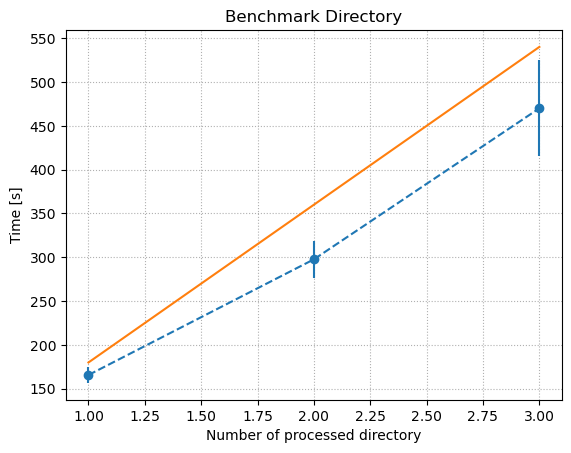

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3]

array = np.load('Bench_files/Benchmark_directory.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')

## Correcting mistake, running the loop for 4 directory 

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for k, n in enumerate(number_directory_list):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', n)

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:n]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, k] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Benchmark_4_directory.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:39:24,169 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,167 - distributed.scheduler - INFO - State start
2023-06-10 20:39:24,174 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,169 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a3aatibd', purging
2023-06-10 20:39:24,341 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,340 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1wukrpef', purging
2023-06-10 20:39:24,356 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,355 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-szhzl7yb', purging
2023-06-10 20:39:24,361 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,360 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h7ft5ym9', purging
2023-06-10 20:39:24,366 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:47:46,960 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,958 - distributed.scheduler - INFO - State start
2023-06-10 20:47:46,980 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,979 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-81u_02f6', purging
2023-06-10 20:47:46,989 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,988 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bhf7fiot', purging
2023-06-10 20:47:46,991 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,990 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pa1kp3zq', purging
2023-06-10 20:47:46,994 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,993 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1fgpptp5', purging
2023-06-10 20:47:47,000 - distributed.deploy.ssh - INFO - 2023-06

## Patch plot

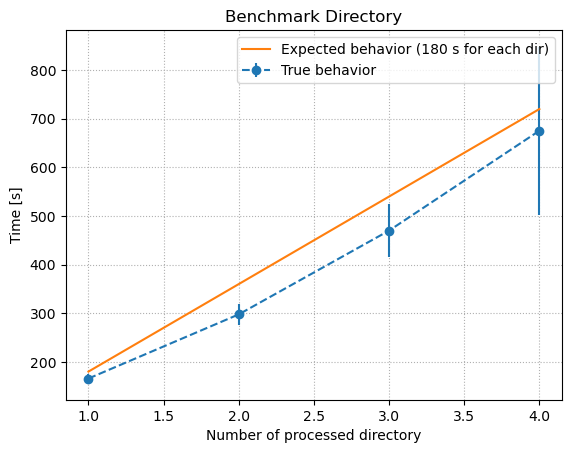

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3,4]

array_1 = np.load('Bench_files/Benchmark_directory.npy')
mean_1 = np.mean(array_1, axis = 0)
std_1 = np.std(array_1, axis = 0)

array_2 = np.load('Bench_files/Benchmark_4_directory.npy')
mean_2 = np.mean(array_2, axis = 0)
std_2 = np.std(array_2, axis = 0)

mean = np.concatenate((mean_1, mean_2), axis=3)
std = np.concatenate((std_1, std_2), axis=3)


fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')
ax.legend()

# Benchmark read_time sync

In [ ]:
cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
client=Client(cluster)

2023-06-10 16:21:37,120 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,119 - distributed.scheduler - INFO - State start
2023-06-10 16:21:37,151 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,150 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-10 16:21:38,165 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,164 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42467'
2023-06-10 16:21:38,176 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,174 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42371'
2023-06-10 16:21:38,186 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,182 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38239'
2023-06-10 16:21:38,199 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,198 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35007'
2023-06-10 16:21:39,074 - distributed.deploy.ssh - INFO - 2023-06-10

In [ ]:
output = dd.read_csv(dir_list[0]+'/0/output_*.csv')
output.columns

Index(['ID', 'name', 'Mass_0', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0', 'RCO_0',
       'Luminosity_0', 'Temperature_0', 'Lambda_0', 'Phase_0', 'PhaseBSE_0',
       'RemnantType_0', 'Zams_0', 'Mass_1', 'MHE_1', 'MCO_1', 'Radius_1',
       'RHE_1', 'RCO_1', 'Luminosity_1', 'Temperature_1', 'Lambda_1',
       'Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Zams_1', 'Semimajor',
       'Eccentricity', 'GWtime', 'BWorldtime', 'BEvent'],
      dtype='object')

In [ ]:
%%time
mean_output = output['name'].count()
mean = dask.compute(mean_output)

CPU times: user 662 ms, sys: 120 ms, total: 782 ms
Wall time: 3min 42s


# Benchmark Grid search (Thread, workers, partitions)

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Benchmark_GridSearch.npy', time_list)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

import dask.dataframe as dd
import dask.array as da
# import dask.bag as db
import dask
from dask.distributed import Client, SSHCluster
import dask.distributed

# import hvplot.dask

In [ ]:
import glob
dir_path = '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_*'
dir_list = glob.glob(dir_path)
print(len(dir_list))

60


In [ ]:
output_column_to_remove = ['ID', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0','RCO_0', 'Luminosity_0', 'Temperature_0', 'Lambda_0',
                               'Phase_0', 'PhaseBSE_0', 'Zams_0', 'MHE_1', 'MCO_1','Radius_1', 'RHE_1', 'RCO_1', 
                               'Luminosity_1', 'Temperature_1','Lambda_1', 'Phase_1', 'PhaseBSE_1', 'Zams_1']
    
evolved_column_to_remove = ['#ID', 'spin_0', 'Tstart_0', 'spin_1', 'Tstart_1', 'Tend', 'Dtout', 'Seed']
drop_list = ['RemnantType_0',  'RemnantType_1']

In [ ]:
def FGpreprocessing(dir_path: str, n_thread: int, output_column_to_remove: list, evolved_column_to_remove: list, drop_list: list):
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#     Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()

    ##################################

    

    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

# Benchmark Workers Threads

In [ ]:
attempt = 10
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files_10/Benchmark_Workers_Threads_10.npy', time_list)

# Plot

 ## Matplotlib 

In [ ]:
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')
array

array([[[496.18939042, 309.44374251, 363.26255941],
        [383.50346351, 403.58574152, 335.96760678],
        [249.42443776, 225.85286474, 201.97225642]],

       [[430.55225253, 284.76588345, 269.20183468],
        [327.67098856, 248.67283058, 244.65126681],
        [303.31334281, 346.56437111, 368.19598842]],

       [[580.6985929 , 411.72727776, 288.80423403],
        [403.49360991, 337.66984129, 315.66719437],
        [323.27917314, 249.95861268, 245.46395135]],

       [[512.35118294, 369.4232645 , 321.72102141],
        [360.65168834, 272.86523509, 250.48180246],
        [339.16766191, 271.98966718, 191.38780403]],

       [[384.58253169, 251.22575355, 222.65730762],
        [220.56649065, 187.8428731 , 157.14735389],
        [167.94112587, 202.3636508 , 209.33047056]]])

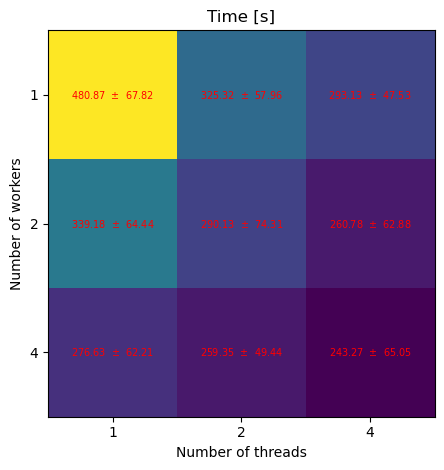

<Figure size 640x480 with 0 Axes>

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, r'%.2f  $\pm$  %.2f' % (mean[w,t], std[w,t]),
                       ha="center", va="center", color="red", fontsize=7)

ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Time [s]')
fig.tight_layout()
plt.figure(figsize=(8, 6), dpi=80)

plt.show()

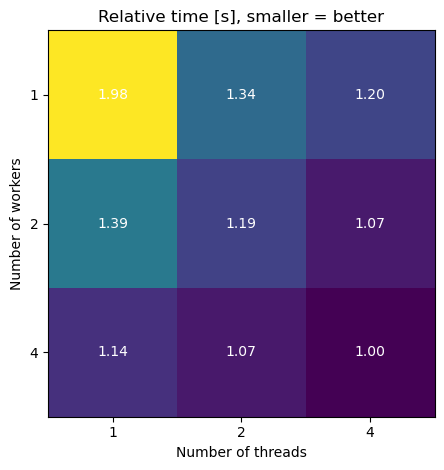

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, '%.2f' %(mean[w,t]/mean.min()),
                       ha="center", va="center", color="w")
ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Relative time [s], smaller = better')
fig.tight_layout()
plt.show()

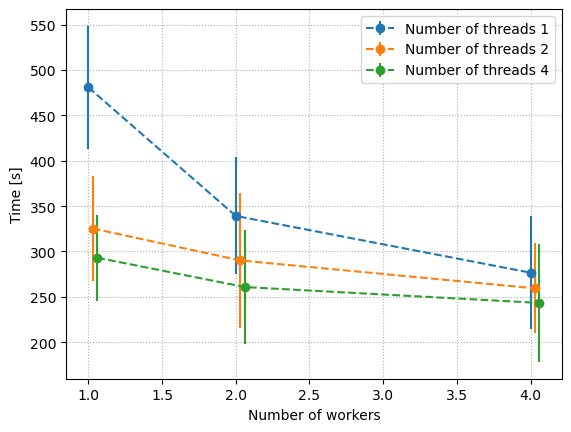

In [ ]:
for k, t in enumerate(threads_list):
    if k == 0:
        plt.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        plt.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        plt.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
plt.grid(linestyle='dotted')
plt.ylabel('Time [s]')
plt.xlabel('Number of workers')
plt.legend()


## Seaborn and Dictionary 

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')

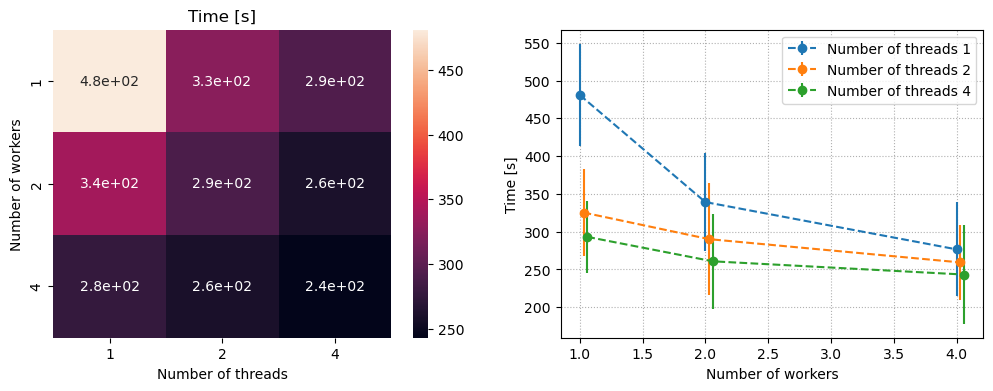

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

df_cm = pd.DataFrame(mean, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 0:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        ax2.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()

### Test to plot sns.heatmap with mean +/- std notation (failed)

In [ ]:
str_mean = np.array(mean, dtype=str).reshape(9)
str_std = np.array(std, dtype=str).reshape(9)

str_array = []
for i in range(len(str_mean)):
    str_array.append(str_mean[i] + '+/-'+ str_std[i])
    
str_array = np.array(str_array)
str_array = str_array.reshape((3,3))
str_array

array([['480.87479009628294+/-67.81540932814285',
        '325.31718435287473+/-57.96199587362794',
        '293.1293914318085+/-47.5261866997072'],
       ['339.1772481918335+/-64.44139219954734',
        '290.127304315567+/-74.31240420156628',
        '260.7830448627472+/-62.883534442304175'],
       ['276.6251482963562+/-62.213373406460136',
        '259.3458333015442+/-49.44453023141172',
        '243.27009415626526+/-65.05455179461765']], dtype='<U38')

ValueError: could not convert string to float: '480.87479009628294+/-67.81540932814285'

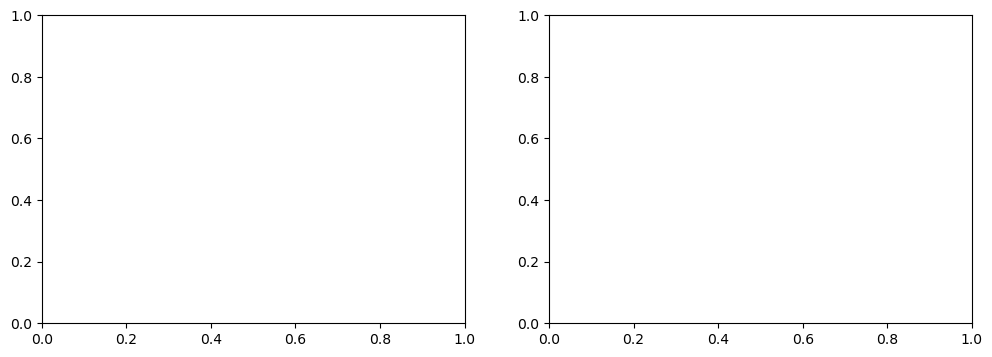

In [ ]:
df_cm = pd.DataFrame(str_array, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 1:
        ax2.errorbar(np.array(workers_list)+0.1, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()


# Benchmar Worker Multiprocessing (poor statistic, no real advantage noticed)

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)
            dask.config.set({'distributed.worker.multiprocessing-method': 'spawn'})

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files/bench_worker_multiprocessing.npy', time_list)

a: 0 	 w: 4 	 t: 4


2023-06-16 08:22:06,766 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,762 - distributed.scheduler - INFO - State start
2023-06-16 08:22:06,772 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,770 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 08:22:07,829 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,827 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35787'
2023-06-16 08:22:07,854 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,852 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36479'
2023-06-16 08:22:07,859 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,856 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35857'
2023-06-16 08:22:07,864 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,860 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33245'
2023-06-16 08:22:08,746 - distributed.deploy.ssh - INFO - 2023-06-16

a: 1 	 w: 4 	 t: 4


2023-06-16 08:25:26,278 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,277 - distributed.scheduler - INFO - State start
2023-06-16 08:25:26,299 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,298 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xmdvrdnz', purging
2023-06-16 08:25:26,397 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,396 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iw1hwwso', purging
2023-06-16 08:25:26,412 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qh8t12kx', purging
2023-06-16 08:25:26,427 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,426 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhl0eg7i', purging
2023-06-16 08:25:26,442 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 4 	 t: 4


2023-06-16 08:28:45,745 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,744 - distributed.scheduler - INFO - State start
2023-06-16 08:28:45,814 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,813 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-po_y4bep', purging
2023-06-16 08:28:46,105 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,104 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hgbd5zvg', purging
2023-06-16 08:28:46,107 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,105 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s2z5dgvi', purging
2023-06-16 08:28:46,111 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,110 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-02ds7uip', purging
2023-06-16 08:28:46,126 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 4 	 t: 4


2023-06-16 08:32:21,079 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,077 - distributed.scheduler - INFO - State start
2023-06-16 08:32:21,134 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,132 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x89xj2f8', purging
2023-06-16 08:32:21,141 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hb98jwx0', purging
2023-06-16 08:32:21,151 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,150 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6mwemqqx', purging
2023-06-16 08:32:21,157 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,156 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yzfbey3q', purging
2023-06-16 08:32:21,163 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 4 	 t: 4


2023-06-16 08:35:44,840 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,837 - distributed.scheduler - INFO - State start
2023-06-16 08:35:44,855 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,853 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zyjv3osx', purging
2023-06-16 08:35:44,883 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,881 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yy1i_bla', purging
2023-06-16 08:35:44,885 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,884 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gwjfjl5s', purging
2023-06-16 08:35:44,889 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,885 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-uxsq9qb7', purging
2023-06-16 08:35:44,894 - distributed.deploy.ssh - INFO - 2023-06

In [ ]:
array = np.load('Bench_files/bench_worker_multiprocessing.npy')
array

array([[[185.79968929]],

       [[187.40345001]],

       [[202.63205862]],

       [[190.16853452]],

       [[199.01239634]]])

In [ ]:
mean, std = np.mean(array), np.std(array)

In [ ]:
print(str(mean) + ' +/- ' + str(std), 'vs', '253 +/- 65')

193.00322575569152 +/- 6.6348843812235545 vs 253 +/- 65


# Benchmark with partitions for output (1, 12, 24)

In [ ]:
def FGpreprocessing_partitions(dir_path: str, n_thread: int, output_column_to_remove: list,
                               evolved_column_to_remove: list, drop_list: list, n_part: int): 
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#    Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove).\
                repartition(npartitions = n_part)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()


    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

In [ ]:
attempt = 10
workers_list = [4]
threads_list = [4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Bench_files_10/Benchmark_divisions_10.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4


2023-06-10 16:30:48,609 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,608 - distributed.scheduler - INFO - State start
2023-06-10 16:30:48,611 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,609 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-za9e9b09', purging
2023-06-10 16:30:48,612 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,610 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s5ksk1s0', purging
2023-06-10 16:30:48,615 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gsazhn76', purging
2023-06-10 16:30:48,616 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x6y027y3', purging
2023-06-10 16:30:48,618 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark divisions

d_1     175.983450
d_2     221.797806
d_12    241.021792
dtype: float64
d_1     13.033073
d_2     22.764691
d_12    22.366035
dtype: float64


Text(0.5, 1.0, 'Benchmark divisions')

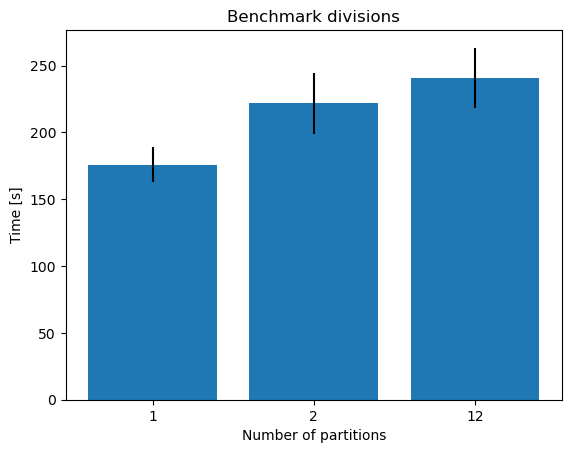

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1, 2, 12] #to br change in the plot in [1,12,24]
array = np.load('Benchmark_divisions.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

array = array.reshape((5, 3))
df = pd.DataFrame(array, columns=['d_1', 'd_2', 'd_12'])
print(df.mean(axis=0))
print(df.std(axis=0))

fig,ax = plt.subplots()
ax.bar(x=['1', '2', '12'], height=df.mean(axis=0), yerr=df.std(axis=0))
ax.set_xlabel('Number of partitions')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark divisions')

# Benchmark number of directory (there is a mistake in the number of directory n, now it has checked n=[0,1,2,3] because of the range(len(number_of_directory))

In [ ]:
attempt = 10
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [1,2,3,4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for n in range(len(number_directory_list)):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', number_directory_list[n])

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:number_directory_list[n]]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, n] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Bench_files_10/Benchmark_directory_10.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 18:52:52,384 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,382 - distributed.scheduler - INFO - State start
2023-06-10 18:52:52,388 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,384 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-frhs3hq1', purging
2023-06-10 18:52:52,389 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,385 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xqpux7kj', purging
2023-06-10 18:52:52,392 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gjb3zpq_', purging
2023-06-10 18:52:52,393 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,387 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3_98msfo', purging
2023-06-10 18:52:52,395 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 18:53:02,321 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,320 - distributed.scheduler - INFO - State start
2023-06-10 18:53:02,324 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,322 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4m4aon0w', purging
2023-06-10 18:53:02,326 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-efwfhmjw', purging
2023-06-10 18:53:02,328 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,326 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-96ahu_ij', purging
2023-06-10 18:53:02,329 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,328 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bwjp2el8', purging
2023-06-10 18:53:02,337 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 18:56:11,511 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,509 - distributed.scheduler - INFO - State start
2023-06-10 18:56:11,513 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,511 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-upjk8ikp', purging
2023-06-10 18:56:11,517 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,517 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0g0uol04', purging
2023-06-10 18:56:11,525 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,524 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mgytvgtc', purging
2023-06-10 18:56:11,530 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,529 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6m5jwu_9', purging
2023-06-10 18:56:11,536 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:01:45,216 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,215 - distributed.scheduler - INFO - State start
2023-06-10 19:01:45,226 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,225 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oabhk91b', purging
2023-06-10 19:01:45,243 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,241 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-cnu6x5qv', purging
2023-06-10 19:01:45,245 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,242 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-exzx9vbk', purging
2023-06-10 19:01:45,247 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,243 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iltqm_j4', purging
2023-06-10 19:01:45,257 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:11:26,462 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,461 - distributed.scheduler - INFO - State start
2023-06-10 19:11:26,481 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,480 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-35ks9ikf', purging
2023-06-10 19:11:26,488 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qtbnv93v', purging
2023-06-10 19:11:26,489 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q9__i13_', purging
2023-06-10 19:11:26,492 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,491 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bqx3w6ss', purging
2023-06-10 19:11:26,500 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:11:33,990 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:33,988 - distributed.scheduler - INFO - State start
2023-06-10 19:11:34,039 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,037 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o3r5755o', purging
2023-06-10 19:11:34,041 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,038 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-g7p32_0x', purging
2023-06-10 19:11:34,042 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-syvvqsd0', purging
2023-06-10 19:11:34,044 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f6tigl2n', purging
2023-06-10 19:11:34,048 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:14:29,888 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,886 - distributed.scheduler - INFO - State start
2023-06-10 19:14:29,896 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,894 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9zdwo6ge', purging
2023-06-10 19:14:29,899 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,895 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0srrtnju', purging
2023-06-10 19:14:29,900 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,896 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zeo7wlfy', purging
2023-06-10 19:14:29,901 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,897 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0nivgn2k', purging
2023-06-10 19:14:29,936 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:20:05,060 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,058 - distributed.scheduler - INFO - State start
2023-06-10 19:20:05,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fe6iluv1', purging
2023-06-10 19:20:05,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mho_gnk2', purging
2023-06-10 19:20:05,074 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a570a1gf', purging
2023-06-10 19:20:05,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ooolqfqd', purging
2023-06-10 19:20:05,084 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:28:22,392 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,390 - distributed.scheduler - INFO - State start
2023-06-10 19:28:22,406 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,405 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4fhwn7bn', purging
2023-06-10 19:28:22,436 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,434 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0x01fcmm', purging
2023-06-10 19:28:22,443 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,442 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ysam46sz', purging
2023-06-10 19:28:22,445 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,443 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fu0ywcjm', purging
2023-06-10 19:28:22,452 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:28:29,824 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,823 - distributed.scheduler - INFO - State start
2023-06-10 19:28:29,830 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-v7443xab', purging
2023-06-10 19:28:29,832 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-701alvl_', purging
2023-06-10 19:28:29,834 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-940bdza_', purging
2023-06-10 19:28:29,841 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-074_ixyc', purging
2023-06-10 19:28:29,842 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:31:22,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,649 - distributed.scheduler - INFO - State start
2023-06-10 19:31:22,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,651 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i5_w6c54', purging
2023-06-10 19:31:22,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rddywufm', purging
2023-06-10 19:31:22,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ejr3929u', purging
2023-06-10 19:31:22,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,653 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6oii9s0b', purging
2023-06-10 19:31:22,717 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:36:23,524 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,523 - distributed.scheduler - INFO - State start
2023-06-10 19:36:23,541 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,539 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fn1itlfa', purging
2023-06-10 19:36:23,599 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8zd7f7n0', purging
2023-06-10 19:36:23,606 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,605 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p6dngpo9', purging
2023-06-10 19:36:23,609 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,607 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oelgh_0v', purging
2023-06-10 19:36:23,615 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:43:41,067 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,065 - distributed.scheduler - INFO - State start
2023-06-10 19:43:41,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,067 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-y_tqv3l1', purging
2023-06-10 19:43:41,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,068 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9463pid_', purging
2023-06-10 19:43:41,076 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2l57wkmw', purging
2023-06-10 19:43:41,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,071 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-re23dx_d', purging
2023-06-10 19:43:41,082 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:43:47,647 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,646 - distributed.scheduler - INFO - State start
2023-06-10 19:43:47,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,654 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8qzhfj2y', purging
2023-06-10 19:43:47,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-do26w1tc', purging
2023-06-10 19:43:47,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-umnsjy0j', purging
2023-06-10 19:43:47,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,656 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bmo9aqd_', purging
2023-06-10 19:43:47,661 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:46:29,943 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,942 - distributed.scheduler - INFO - State start
2023-06-10 19:46:29,951 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,950 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l9u3iy6i', purging
2023-06-10 19:46:29,953 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,951 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f28aueqo', purging
2023-06-10 19:46:29,955 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,952 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1x0uc7p6', purging
2023-06-10 19:46:29,961 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,961 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-e0jehsr8', purging
2023-06-10 19:46:29,967 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:51:19,423 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,421 - distributed.scheduler - INFO - State start
2023-06-10 19:51:19,434 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,432 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mbr8fc27', purging
2023-06-10 19:51:19,446 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,445 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bu4gzx0k', purging
2023-06-10 19:51:19,454 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,453 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-72xvn65t', purging
2023-06-10 19:51:19,456 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,455 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oifzidto', purging
2023-06-10 19:51:19,463 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:58:31,132 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,131 - distributed.scheduler - INFO - State start
2023-06-10 19:58:31,147 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gh6pkn5w', purging
2023-06-10 19:58:31,156 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,155 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rjv1gmj1', purging
2023-06-10 19:58:31,161 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,160 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xk1r_e06', purging
2023-06-10 19:58:31,164 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,162 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lxw95059', purging
2023-06-10 19:58:31,170 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:58:38,643 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,642 - distributed.scheduler - INFO - State start
2023-06-10 19:58:38,648 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,643 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-psm_c8ti', purging
2023-06-10 19:58:38,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,644 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o9cacubu', purging
2023-06-10 19:58:38,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ebrmf1kx', purging
2023-06-10 19:58:38,656 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k03qy6ac', purging
2023-06-10 19:58:38,657 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 20:01:22,537 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,536 - distributed.scheduler - INFO - State start
2023-06-10 20:01:22,541 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,538 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yez1v_lh', purging
2023-06-10 20:01:22,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i6ejebgt', purging
2023-06-10 20:01:22,550 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhcp8kgq', purging
2023-06-10 20:01:22,551 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ydpzswlm', purging
2023-06-10 20:01:22,554 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:06:01,502 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,500 - distributed.scheduler - INFO - State start
2023-06-10 20:06:01,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-n4fl32df', purging
2023-06-10 20:06:01,600 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ew6i70nj', purging
2023-06-10 20:06:01,602 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,600 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_axnxr_m', purging
2023-06-10 20:06:01,605 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,601 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhrs_pc7', purging
2023-06-10 20:06:01,609 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark directory

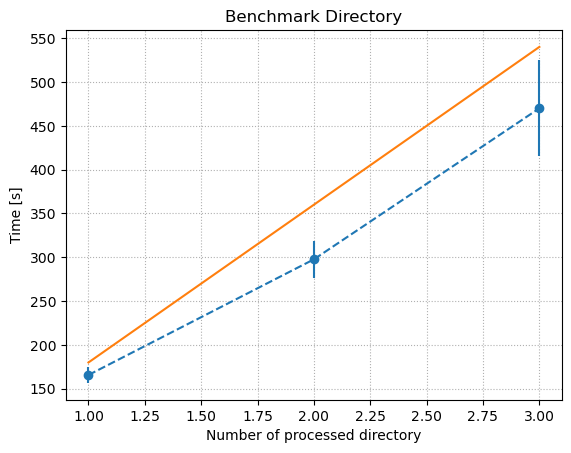

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3]

array = np.load('Bench_files/Benchmark_directory.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')

## Correcting mistake, running the loop for 4 directory 

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for k, n in enumerate(number_directory_list):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', n)

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:n]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, k] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Benchmark_4_directory.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:39:24,169 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,167 - distributed.scheduler - INFO - State start
2023-06-10 20:39:24,174 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,169 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a3aatibd', purging
2023-06-10 20:39:24,341 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,340 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1wukrpef', purging
2023-06-10 20:39:24,356 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,355 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-szhzl7yb', purging
2023-06-10 20:39:24,361 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,360 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h7ft5ym9', purging
2023-06-10 20:39:24,366 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:47:46,960 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,958 - distributed.scheduler - INFO - State start
2023-06-10 20:47:46,980 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,979 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-81u_02f6', purging
2023-06-10 20:47:46,989 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,988 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bhf7fiot', purging
2023-06-10 20:47:46,991 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,990 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pa1kp3zq', purging
2023-06-10 20:47:46,994 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,993 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1fgpptp5', purging
2023-06-10 20:47:47,000 - distributed.deploy.ssh - INFO - 2023-06

## Patch plot

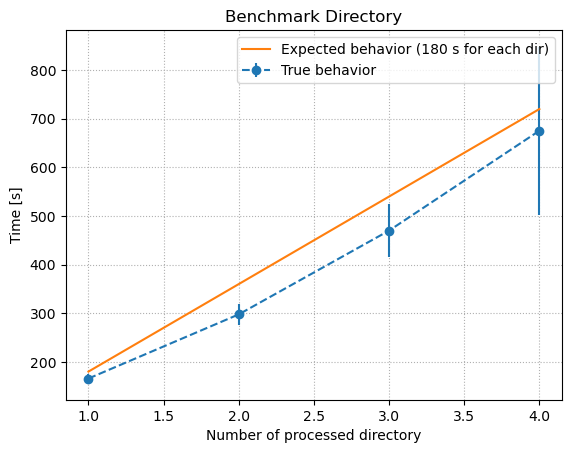

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3,4]

array_1 = np.load('Bench_files/Benchmark_directory.npy')
mean_1 = np.mean(array_1, axis = 0)
std_1 = np.std(array_1, axis = 0)

array_2 = np.load('Bench_files/Benchmark_4_directory.npy')
mean_2 = np.mean(array_2, axis = 0)
std_2 = np.std(array_2, axis = 0)

mean = np.concatenate((mean_1, mean_2), axis=3)
std = np.concatenate((std_1, std_2), axis=3)


fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')
ax.legend()

# Benchmark read_time sync

In [ ]:
cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
client=Client(cluster)

2023-06-10 16:21:37,120 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,119 - distributed.scheduler - INFO - State start
2023-06-10 16:21:37,151 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,150 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-10 16:21:38,165 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,164 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42467'
2023-06-10 16:21:38,176 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,174 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42371'
2023-06-10 16:21:38,186 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,182 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38239'
2023-06-10 16:21:38,199 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,198 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35007'
2023-06-10 16:21:39,074 - distributed.deploy.ssh - INFO - 2023-06-10

In [ ]:
output = dd.read_csv(dir_list[0]+'/0/output_*.csv')
output.columns

Index(['ID', 'name', 'Mass_0', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0', 'RCO_0',
       'Luminosity_0', 'Temperature_0', 'Lambda_0', 'Phase_0', 'PhaseBSE_0',
       'RemnantType_0', 'Zams_0', 'Mass_1', 'MHE_1', 'MCO_1', 'Radius_1',
       'RHE_1', 'RCO_1', 'Luminosity_1', 'Temperature_1', 'Lambda_1',
       'Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Zams_1', 'Semimajor',
       'Eccentricity', 'GWtime', 'BWorldtime', 'BEvent'],
      dtype='object')

In [ ]:
%%time
mean_output = output['name'].count()
mean = dask.compute(mean_output)

CPU times: user 662 ms, sys: 120 ms, total: 782 ms
Wall time: 3min 42s


# Benchmark Grid search (Thread, workers, partitions)

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Benchmark_GridSearch.npy', time_list)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

import dask.dataframe as dd
import dask.array as da
# import dask.bag as db
import dask
from dask.distributed import Client, SSHCluster
import dask.distributed

# import hvplot.dask

In [ ]:
import glob
dir_path = '/mnt/bhbh/fiducial_Hrad_5M/sevn_output_*'
dir_list = glob.glob(dir_path)
print(len(dir_list))

60


In [ ]:
output_column_to_remove = ['ID', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0','RCO_0', 'Luminosity_0', 'Temperature_0', 'Lambda_0',
                               'Phase_0', 'PhaseBSE_0', 'Zams_0', 'MHE_1', 'MCO_1','Radius_1', 'RHE_1', 'RCO_1', 
                               'Luminosity_1', 'Temperature_1','Lambda_1', 'Phase_1', 'PhaseBSE_1', 'Zams_1']
    
evolved_column_to_remove = ['#ID', 'spin_0', 'Tstart_0', 'spin_1', 'Tstart_1', 'Tend', 'Dtout', 'Seed']
drop_list = ['RemnantType_0',  'RemnantType_1']

In [ ]:
def FGpreprocessing(dir_path: str, n_thread: int, output_column_to_remove: list, evolved_column_to_remove: list, drop_list: list):
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#     Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()

    ##################################

    

    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

# Benchmark Workers Threads

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Benchmark_Workers_Threads.npy', time_list)

a: 0 	 w: 1 	 t: 1


2023-06-09 17:04:22,119 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:22,117 - distributed.scheduler - INFO - State start
2023-06-09 17:04:22,127 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:22,119 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-j244lalc', purging
2023-06-09 17:04:22,140 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:22,138 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:04:23,180 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:23,178 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45873'
2023-06-09 17:04:24,089 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:24,088 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:34709
2023-06-09 17:04:26,321 - distributed.deploy.ssh - INFO - 2023-06-09 17:04:26,313 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:45773'
2023-06-09 17:04:26,724 - dis

a: 0 	 w: 1 	 t: 2


2023-06-09 17:12:52,993 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:52,992 - distributed.scheduler - INFO - State start
2023-06-09 17:12:52,996 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:52,993 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l9x6js6p', purging
2023-06-09 17:12:53,028 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:53,027 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:12:54,004 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:54,003 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43361'
2023-06-09 17:12:54,906 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:54,905 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44101
2023-06-09 17:12:57,004 - distributed.deploy.ssh - INFO - 2023-06-09 17:12:56,999 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:37585'
2023-06-09 17:12:57,373 - dis

a: 0 	 w: 1 	 t: 4


2023-06-09 17:18:14,874 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:14,872 - distributed.scheduler - INFO - State start
2023-06-09 17:18:14,880 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:14,879 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ac6m7pfy', purging
2023-06-09 17:18:14,886 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:14,884 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:18:15,873 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:15,871 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36807'
2023-06-09 17:18:16,766 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:16,764 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:37025
2023-06-09 17:18:18,746 - distributed.deploy.ssh - INFO - 2023-06-09 17:18:18,742 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:40833'
2023-06-09 17:18:18,908 - dis

a: 0 	 w: 2 	 t: 1


2023-06-09 17:24:30,698 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:30,696 - distributed.scheduler - INFO - State start
2023-06-09 17:24:30,701 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:30,698 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-j5iqtbyb', purging
2023-06-09 17:24:30,708 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:30,706 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:24:31,716 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:31,715 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38509'
2023-06-09 17:24:31,748 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:31,747 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41563'
2023-06-09 17:24:32,546 - distributed.deploy.ssh - INFO - 2023-06-09 17:24:32,539 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:32967
2023-06-09 17:24:32,547 - di

a: 0 	 w: 2 	 t: 2


2023-06-09 17:31:06,160 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,158 - distributed.scheduler - INFO - State start
2023-06-09 17:31:06,170 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,169 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ztrbmpux', purging
2023-06-09 17:31:06,197 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,196 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iiuuq3lo', purging
2023-06-09 17:31:06,207 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:06,206 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:31:07,195 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:07,194 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38015'
2023-06-09 17:31:07,213 - distributed.deploy.ssh - INFO - 2023-06-09 17:31:07,211 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 2 	 t: 4


2023-06-09 17:38:02,807 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,805 - distributed.scheduler - INFO - State start
2023-06-09 17:38:02,816 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,807 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_lhm6x02', purging
2023-06-09 17:38:02,855 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,854 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2o_rdx4t', purging
2023-06-09 17:38:02,866 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:02,865 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:38:03,859 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:03,858 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45899'
2023-06-09 17:38:03,879 - distributed.deploy.ssh - INFO - 2023-06-09 17:38:03,877 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 4 	 t: 1


2023-06-09 17:43:49,804 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:49,803 - distributed.scheduler - INFO - State start
2023-06-09 17:43:49,879 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:49,878 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x19sh8ks', purging
2023-06-09 17:43:49,921 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:49,920 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-sr7fjs2n', purging
2023-06-09 17:43:50,046 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:50,044 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 17:43:51,081 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:51,080 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45079'
2023-06-09 17:43:51,097 - distributed.deploy.ssh - INFO - 2023-06-09 17:43:51,096 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 0 	 w: 4 	 t: 2


2023-06-09 17:48:10,139 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,137 - distributed.scheduler - INFO - State start
2023-06-09 17:48:10,146 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,144 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-goxknqve', purging
2023-06-09 17:48:10,148 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hqehm5vr', purging
2023-06-09 17:48:10,149 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,146 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-b70bl5k3', purging
2023-06-09 17:48:10,152 - distributed.deploy.ssh - INFO - 2023-06-09 17:48:10,146 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9wsehqbf', purging
2023-06-09 17:48:10,155 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 w: 4 	 t: 4


2023-06-09 17:52:10,886 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,884 - distributed.scheduler - INFO - State start
2023-06-09 17:52:10,889 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,886 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dqnfpr6r', purging
2023-06-09 17:52:10,898 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,897 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s9k25zwx', purging
2023-06-09 17:52:10,904 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,903 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3oqkrspz', purging
2023-06-09 17:52:10,907 - distributed.deploy.ssh - INFO - 2023-06-09 17:52:10,904 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rb3y1o6h', purging
2023-06-09 17:52:10,912 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 w: 1 	 t: 1


2023-06-09 17:55:46,190 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,188 - distributed.scheduler - INFO - State start
2023-06-09 17:55:46,204 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,202 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8dppa8am', purging
2023-06-09 17:55:46,260 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,259 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0mabqn8c', purging
2023-06-09 17:55:46,265 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,263 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qy75209k', purging
2023-06-09 17:55:46,271 - distributed.deploy.ssh - INFO - 2023-06-09 17:55:46,270 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3t17ditj', purging
2023-06-09 17:55:46,277 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 w: 1 	 t: 2


2023-06-09 18:03:07,586 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:07,584 - distributed.scheduler - INFO - State start
2023-06-09 18:03:07,590 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:07,586 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-35hbo06x', purging
2023-06-09 18:03:07,599 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:07,598 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:03:08,575 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:08,573 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39161'
2023-06-09 18:03:09,417 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:09,415 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:36107
2023-06-09 18:03:10,209 - distributed.deploy.ssh - INFO - 2023-06-09 18:03:10,206 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:46651'
2023-06-09 18:03:10,556 - dis

a: 1 	 w: 1 	 t: 4


2023-06-09 18:08:02,056 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:02,054 - distributed.scheduler - INFO - State start
2023-06-09 18:08:02,063 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:02,062 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p6wf0k9y', purging
2023-06-09 18:08:02,069 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:02,068 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:08:03,081 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:03,080 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36155'
2023-06-09 18:08:04,455 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:04,453 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:44571'
2023-06-09 18:08:04,700 - distributed.deploy.ssh - INFO - 2023-06-09 18:08:04,699 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44961
2023-06-09 18:08:04,790 - dis

a: 1 	 w: 2 	 t: 1


2023-06-09 18:12:41,550 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:41,549 - distributed.scheduler - INFO - State start
2023-06-09 18:12:41,553 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:41,551 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a_9n7puw', purging
2023-06-09 18:12:41,565 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:41,564 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:12:42,547 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:42,545 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39429'
2023-06-09 18:12:42,566 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:42,564 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43507'
2023-06-09 18:12:43,334 - distributed.deploy.ssh - INFO - 2023-06-09 18:12:43,332 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:32881
2023-06-09 18:12:43,335 - di

a: 1 	 w: 2 	 t: 2


2023-06-09 18:18:20,826 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,825 - distributed.scheduler - INFO - State start
2023-06-09 18:18:20,844 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,842 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xrjdgrtj', purging
2023-06-09 18:18:20,851 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,850 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xubklxx4', purging
2023-06-09 18:18:20,863 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:20,862 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:18:21,763 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:21,762 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41253'
2023-06-09 18:18:21,775 - distributed.deploy.ssh - INFO - 2023-06-09 18:18:21,773 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 1 	 w: 2 	 t: 4


2023-06-09 18:22:41,200 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,199 - distributed.scheduler - INFO - State start
2023-06-09 18:22:41,205 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,204 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0pwsr8pt', purging
2023-06-09 18:22:41,212 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,212 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gj2joxsu', purging
2023-06-09 18:22:41,218 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:41,217 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:22:42,114 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:42,113 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34177'
2023-06-09 18:22:42,130 - distributed.deploy.ssh - INFO - 2023-06-09 18:22:42,129 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 1 	 w: 4 	 t: 1


2023-06-09 18:26:55,106 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,105 - distributed.scheduler - INFO - State start
2023-06-09 18:26:55,119 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,118 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-jyf_8ijp', purging
2023-06-09 18:26:55,121 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,118 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q4_n1r8s', purging
2023-06-09 18:26:55,174 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:55,173 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:26:56,203 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:56,202 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38459'
2023-06-09 18:26:56,272 - distributed.deploy.ssh - INFO - 2023-06-09 18:26:56,271 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 1 	 w: 4 	 t: 4


2023-06-09 18:38:10,249 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,246 - distributed.scheduler - INFO - State start
2023-06-09 18:38:10,258 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,257 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8w9j7x4p', purging
2023-06-09 18:38:10,264 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,263 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0w09meqk', purging
2023-06-09 18:38:10,267 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,264 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bi362lu5', purging
2023-06-09 18:38:10,268 - distributed.deploy.ssh - INFO - 2023-06-09 18:38:10,264 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l5whf4g2', purging
2023-06-09 18:38:10,271 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 1 	 t: 1


2023-06-09 18:44:30,086 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,084 - distributed.scheduler - INFO - State start
2023-06-09 18:44:30,091 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,090 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6mdjgmxw', purging
2023-06-09 18:44:30,114 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,112 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qp1d4wv5', purging
2023-06-09 18:44:30,120 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,119 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zitfrvy8', purging
2023-06-09 18:44:30,123 - distributed.deploy.ssh - INFO - 2023-06-09 18:44:30,122 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l019y3xk', purging
2023-06-09 18:44:30,131 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 1 	 t: 2


2023-06-09 18:54:22,457 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:22,455 - distributed.scheduler - INFO - State start
2023-06-09 18:54:22,465 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:22,463 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8ew3ay7g', purging
2023-06-09 18:54:22,490 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:22,489 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 18:54:23,380 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:23,379 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:44063'
2023-06-09 18:54:24,202 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:24,200 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:46671
2023-06-09 18:54:25,937 - distributed.deploy.ssh - INFO - 2023-06-09 18:54:25,934 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.220:35039'
2023-06-09 18:54:25,990 - di

a: 2 	 w: 1 	 t: 4


2023-06-09 19:01:24,653 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:24,651 - distributed.scheduler - INFO - State start
2023-06-09 19:01:24,657 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:24,653 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-vi22aita', purging
2023-06-09 19:01:24,660 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:24,659 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:01:25,618 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:25,617 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37617'
2023-06-09 19:01:26,448 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:26,447 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44673
2023-06-09 19:01:27,739 - distributed.deploy.ssh - INFO - 2023-06-09 19:01:27,737 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.31:39529'
2023-06-09 19:01:27,910 - dis

a: 2 	 w: 2 	 t: 1


2023-06-09 19:06:24,020 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:24,019 - distributed.scheduler - INFO - State start
2023-06-09 19:06:24,037 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:24,035 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xyy8sm6l', purging
2023-06-09 19:06:24,042 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:24,041 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:06:25,051 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:25,048 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45207'
2023-06-09 19:06:25,087 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:25,086 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33031'
2023-06-09 19:06:25,907 - distributed.deploy.ssh - INFO - 2023-06-09 19:06:25,903 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:42935
2023-06-09 19:06:25,909 - di

a: 2 	 w: 2 	 t: 2


2023-06-09 19:13:17,881 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,879 - distributed.scheduler - INFO - State start
2023-06-09 19:13:17,887 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,885 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c7dchzzz', purging
2023-06-09 19:13:17,890 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,887 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k0oyssc2', purging
2023-06-09 19:13:17,895 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:17,894 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:13:18,868 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:18,867 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35231'
2023-06-09 19:13:18,895 - distributed.deploy.ssh - INFO - 2023-06-09 19:13:18,894 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 2 	 w: 2 	 t: 4


2023-06-09 19:19:07,585 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,583 - distributed.scheduler - INFO - State start
2023-06-09 19:19:07,595 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,593 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8_1u06jz', purging
2023-06-09 19:19:07,602 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,601 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1wwrewcj', purging
2023-06-09 19:19:07,611 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:07,610 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:19:08,549 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:08,547 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:46117'
2023-06-09 19:19:08,570 - distributed.deploy.ssh - INFO - 2023-06-09 19:19:08,569 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 2 	 w: 4 	 t: 1


2023-06-09 19:24:35,029 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,028 - distributed.scheduler - INFO - State start
2023-06-09 19:24:35,041 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,040 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7jj352yt', purging
2023-06-09 19:24:35,045 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,041 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c4h12pik', purging
2023-06-09 19:24:35,055 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:35,054 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:24:36,047 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:36,045 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34567'
2023-06-09 19:24:36,067 - distributed.deploy.ssh - INFO - 2023-06-09 19:24:36,066 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 2 	 w: 4 	 t: 2


2023-06-09 19:30:10,136 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,134 - distributed.scheduler - INFO - State start
2023-06-09 19:30:10,141 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iefdgk7j', purging
2023-06-09 19:30:10,148 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,148 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pu8l6vsg', purging
2023-06-09 19:30:10,154 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,153 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9w73haqe', purging
2023-06-09 19:30:10,158 - distributed.deploy.ssh - INFO - 2023-06-09 19:30:10,155 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h7a7_ogt', purging
2023-06-09 19:30:10,163 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 4 	 t: 4


2023-06-09 19:34:34,797 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,795 - distributed.scheduler - INFO - State start
2023-06-09 19:34:34,805 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,804 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p5bhst7c', purging
2023-06-09 19:34:34,827 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3mpzsk_k', purging
2023-06-09 19:34:34,829 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,827 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zvbpxd3x', purging
2023-06-09 19:34:34,831 - distributed.deploy.ssh - INFO - 2023-06-09 19:34:34,827 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6hxp8u50', purging
2023-06-09 19:34:34,836 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 1 	 t: 1


2023-06-09 19:38:53,204 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,203 - distributed.scheduler - INFO - State start
2023-06-09 19:38:53,214 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,213 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-jk_zkoss', purging
2023-06-09 19:38:53,250 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,249 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7y5aw84u', purging
2023-06-09 19:38:53,253 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,251 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-7ha8ne3u', purging
2023-06-09 19:38:53,255 - distributed.deploy.ssh - INFO - 2023-06-09 19:38:53,255 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-j1tvulup', purging
2023-06-09 19:38:53,267 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 1 	 t: 2


2023-06-09 19:47:36,603 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:36,601 - distributed.scheduler - INFO - State start
2023-06-09 19:47:36,615 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:36,614 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ajad0aye', purging
2023-06-09 19:47:36,630 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:36,629 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:47:37,562 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:37,561 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:40549'
2023-06-09 19:47:38,895 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:38,893 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:36057
2023-06-09 19:47:39,659 - distributed.deploy.ssh - INFO - 2023-06-09 19:47:39,654 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:42295'
2023-06-09 19:47:39,788 - dis

a: 3 	 w: 1 	 t: 4


2023-06-09 19:53:56,834 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:56,833 - distributed.scheduler - INFO - State start
2023-06-09 19:53:56,837 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:56,835 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xvefl716', purging
2023-06-09 19:53:56,840 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:56,840 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:53:57,794 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:57,792 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34787'
2023-06-09 19:53:58,582 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:58,581 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:40407
2023-06-09 19:53:59,673 - distributed.deploy.ssh - INFO - 2023-06-09 19:53:59,669 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:42289'
2023-06-09 19:53:59,922 - dis

a: 3 	 w: 2 	 t: 1


2023-06-09 19:59:29,474 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:29,472 - distributed.scheduler - INFO - State start
2023-06-09 19:59:29,484 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:29,482 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-atqjgg1c', purging
2023-06-09 19:59:29,494 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:29,493 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 19:59:30,495 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:30,493 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41479'
2023-06-09 19:59:30,507 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:30,505 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35911'
2023-06-09 19:59:31,290 - distributed.deploy.ssh - INFO - 2023-06-09 19:59:31,289 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:33051
2023-06-09 19:59:31,298 - di

a: 3 	 w: 2 	 t: 2


2023-06-09 20:05:41,098 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,097 - distributed.scheduler - INFO - State start
2023-06-09 20:05:41,122 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,120 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rbg8kgnu', purging
2023-06-09 20:05:41,128 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,127 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-nd98u98q', purging
2023-06-09 20:05:41,133 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:41,133 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:05:42,113 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:42,112 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33289'
2023-06-09 20:05:42,121 - distributed.deploy.ssh - INFO - 2023-06-09 20:05:42,120 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 3 	 w: 2 	 t: 4


2023-06-09 20:10:25,418 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,416 - distributed.scheduler - INFO - State start
2023-06-09 20:10:25,431 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,429 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mzytht2u', purging
2023-06-09 20:10:25,439 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,438 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qzttkr19', purging
2023-06-09 20:10:25,456 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:25,455 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:10:26,374 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:26,373 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35469'
2023-06-09 20:10:26,388 - distributed.deploy.ssh - INFO - 2023-06-09 20:10:26,387 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 3 	 w: 4 	 t: 1


2023-06-09 20:14:46,212 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,211 - distributed.scheduler - INFO - State start
2023-06-09 20:14:46,215 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,213 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-kg97ie4z', purging
2023-06-09 20:14:46,217 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,213 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-by488iia', purging
2023-06-09 20:14:46,224 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:46,223 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:14:47,164 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:47,162 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38441'
2023-06-09 20:14:47,175 - distributed.deploy.ssh - INFO - 2023-06-09 20:14:47,174 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 3 	 w: 4 	 t: 2


2023-06-09 20:20:36,925 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,923 - distributed.scheduler - INFO - State start
2023-06-09 20:20:36,936 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,935 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p2yu8dlp', purging
2023-06-09 20:20:36,947 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,946 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ctni5rje', purging
2023-06-09 20:20:36,948 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,946 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c_kt9pez', purging
2023-06-09 20:20:36,950 - distributed.deploy.ssh - INFO - 2023-06-09 20:20:36,948 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-w6w1_poy', purging
2023-06-09 20:20:36,954 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 4 	 t: 4


2023-06-09 20:25:20,609 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,608 - distributed.scheduler - INFO - State start
2023-06-09 20:25:20,627 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,625 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2779cfu0', purging
2023-06-09 20:25:20,640 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,639 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l4fptxso', purging
2023-06-09 20:25:20,645 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,644 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-eki9vshj', purging
2023-06-09 20:25:20,646 - distributed.deploy.ssh - INFO - 2023-06-09 20:25:20,646 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-w986_6c7', purging
2023-06-09 20:25:20,653 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 1 	 t: 1


2023-06-09 20:28:44,285 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,284 - distributed.scheduler - INFO - State start
2023-06-09 20:28:44,307 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,306 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6sld8nb3', purging
2023-06-09 20:28:44,367 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,366 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dxbn8zht', purging
2023-06-09 20:28:44,377 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,376 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3y7lli3_', purging
2023-06-09 20:28:44,383 - distributed.deploy.ssh - INFO - 2023-06-09 20:28:44,382 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9m4mfluw', purging
2023-06-09 20:28:44,394 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 1 	 t: 2


2023-06-09 20:35:18,921 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:18,918 - distributed.scheduler - INFO - State start
2023-06-09 20:35:18,926 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:18,920 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-09ijbxmx', purging
2023-06-09 20:35:18,929 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:18,926 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:35:19,934 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:19,932 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36089'
2023-06-09 20:35:20,752 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:20,748 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:44779
2023-06-09 20:35:21,578 - distributed.deploy.ssh - INFO - 2023-06-09 20:35:21,574 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:45949'
2023-06-09 20:35:21,947 - dis

a: 4 	 w: 1 	 t: 4


2023-06-09 20:39:39,563 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:39,561 - distributed.scheduler - INFO - State start
2023-06-09 20:39:39,601 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:39,600 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qvzuohs_', purging
2023-06-09 20:39:39,606 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:39,606 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:39:40,458 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:40,456 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:37851'
2023-06-09 20:39:41,195 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:41,193 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:45149
2023-06-09 20:39:42,290 - distributed.deploy.ssh - INFO - 2023-06-09 20:39:42,286 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.21:41789'
2023-06-09 20:39:42,649 - dis

a: 4 	 w: 2 	 t: 1


2023-06-09 20:43:32,311 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:32,309 - distributed.scheduler - INFO - State start
2023-06-09 20:43:32,350 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:32,348 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lh9yd33b', purging
2023-06-09 20:43:32,365 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:32,363 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:43:33,300 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:33,299 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34585'
2023-06-09 20:43:33,312 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:33,311 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:34339'
2023-06-09 20:43:34,041 - distributed.deploy.ssh - INFO - 2023-06-09 20:43:34,034 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.140:40143
2023-06-09 20:43:34,042 - di

a: 4 	 w: 2 	 t: 2


2023-06-09 20:47:22,247 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,246 - distributed.scheduler - INFO - State start
2023-06-09 20:47:22,253 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,252 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lx9cl9q5', purging
2023-06-09 20:47:22,283 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,282 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-berr1zme', purging
2023-06-09 20:47:22,288 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:22,288 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:47:23,212 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:23,211 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43077'
2023-06-09 20:47:23,225 - distributed.deploy.ssh - INFO - 2023-06-09 20:47:23,224 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 4 	 w: 2 	 t: 4


2023-06-09 20:50:40,666 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,665 - distributed.scheduler - INFO - State start
2023-06-09 20:50:40,696 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,695 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dui5_lh1', purging
2023-06-09 20:50:40,704 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,703 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-n8c29rd3', purging
2023-06-09 20:50:40,710 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:40,709 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:50:41,597 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:41,595 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:41151'
2023-06-09 20:50:41,607 - distributed.deploy.ssh - INFO - 2023-06-09 20:50:41,606 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 4 	 w: 4 	 t: 1


2023-06-09 20:53:27,695 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,693 - distributed.scheduler - INFO - State start
2023-06-09 20:53:27,698 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,695 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ur5sk6_w', purging
2023-06-09 20:53:27,745 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,743 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-tplpgv9l', purging
2023-06-09 20:53:27,754 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:27,753 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-09 20:53:28,721 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:28,720 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33195'
2023-06-09 20:53:28,734 - distributed.deploy.ssh - INFO - 2023-06-09 20:53:28,733 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22

a: 4 	 w: 4 	 t: 2


2023-06-09 20:56:25,962 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,960 - distributed.scheduler - INFO - State start
2023-06-09 20:56:25,970 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h6zk0ds_', purging
2023-06-09 20:56:25,972 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,969 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k9hulyw_', purging
2023-06-09 20:56:25,973 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,970 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0340b2ko', purging
2023-06-09 20:56:25,974 - distributed.deploy.ssh - INFO - 2023-06-09 20:56:25,970 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mb3csmsu', purging
2023-06-09 20:56:26,023 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 4 	 t: 4


2023-06-09 21:00:00,432 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,430 - distributed.scheduler - INFO - State start
2023-06-09 21:00:00,452 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,450 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q4gt_rvz', purging
2023-06-09 21:00:00,465 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,464 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-swbadx_f', purging
2023-06-09 21:00:00,470 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,470 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-c3d_9xbb', purging
2023-06-09 21:00:00,472 - distributed.deploy.ssh - INFO - 2023-06-09 21:00:00,470 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-58x6hfaf', purging
2023-06-09 21:00:00,478 - distributed.deploy.ssh - INFO - 2023-06

# Plot

 ## Matplotlib 

In [ ]:
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')
array

array([[[496.18939042, 309.44374251, 363.26255941],
        [383.50346351, 403.58574152, 335.96760678],
        [249.42443776, 225.85286474, 201.97225642]],

       [[430.55225253, 284.76588345, 269.20183468],
        [327.67098856, 248.67283058, 244.65126681],
        [303.31334281, 346.56437111, 368.19598842]],

       [[580.6985929 , 411.72727776, 288.80423403],
        [403.49360991, 337.66984129, 315.66719437],
        [323.27917314, 249.95861268, 245.46395135]],

       [[512.35118294, 369.4232645 , 321.72102141],
        [360.65168834, 272.86523509, 250.48180246],
        [339.16766191, 271.98966718, 191.38780403]],

       [[384.58253169, 251.22575355, 222.65730762],
        [220.56649065, 187.8428731 , 157.14735389],
        [167.94112587, 202.3636508 , 209.33047056]]])

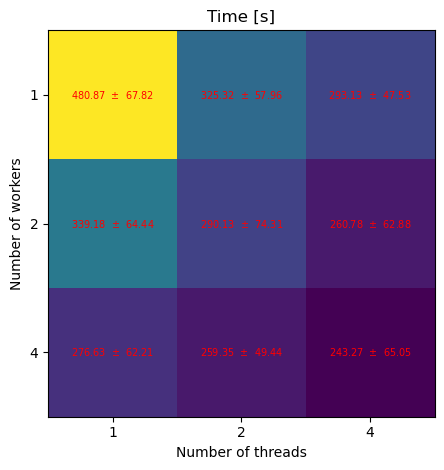

<Figure size 640x480 with 0 Axes>

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, r'%.2f  $\pm$  %.2f' % (mean[w,t], std[w,t]),
                       ha="center", va="center", color="red", fontsize=7)

ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Time [s]')
fig.tight_layout()
plt.figure(figsize=(8, 6), dpi=80)

plt.show()

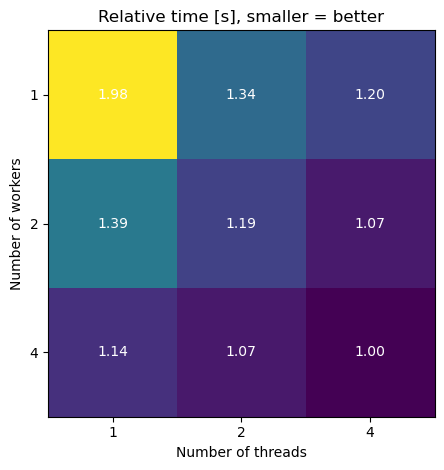

In [ ]:
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

# df_cm = pd.DataFrame(mean, index = [str(t) for t in threads_list],
#                   columns = [str(w) for w in workers_list])
# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True)

fig, ax = plt.subplots()
im = ax.imshow(mean)

ax.set_xticks(np.arange(len(threads_list)), labels=np.array(threads_list, dtype=str))
ax.set_yticks(np.arange(len(workers_list)), labels=np.array(workers_list, dtype=str))

for w in range(len(workers_list)):
    for t in range(len(threads_list)):
        text = ax.text(t, w, '%.2f' %(mean[w,t]/mean.min()),
                       ha="center", va="center", color="w")
ax.set_xlabel('Number of threads')
ax.set_ylabel('Number of workers')
ax.set_title('Relative time [s], smaller = better')
fig.tight_layout()
plt.show()

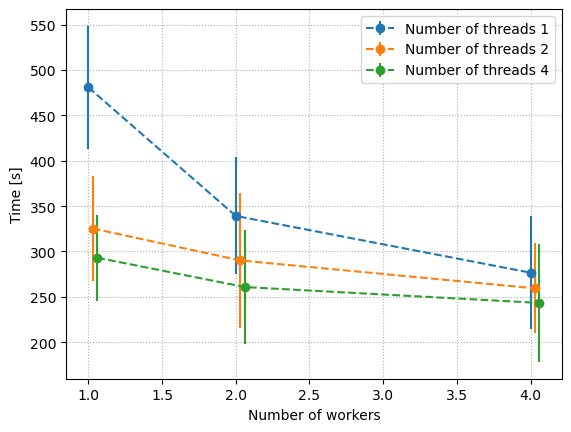

In [ ]:
for k, t in enumerate(threads_list):
    if k == 0:
        plt.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        plt.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        plt.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
plt.grid(linestyle='dotted')
plt.ylabel('Time [s]')
plt.xlabel('Number of workers')
plt.legend()


# Seaborn and Dictionary 

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
array = np.load('Bench_files/Benchmark_Workers_Threads.npy')

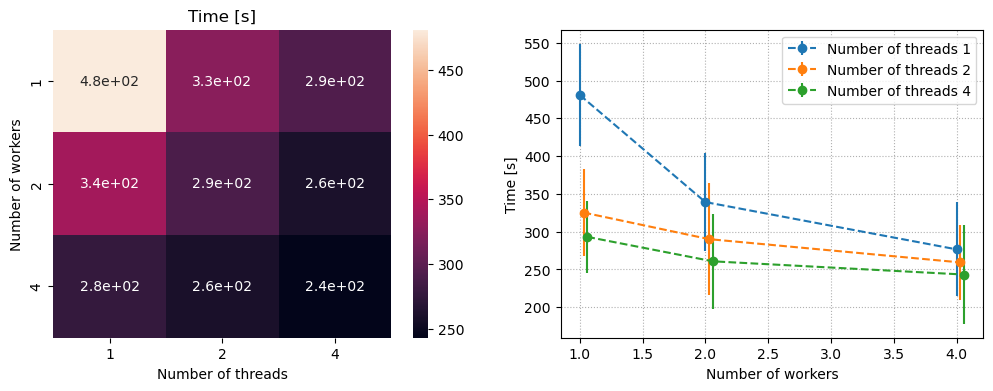

In [ ]:
mean = np.mean(array, axis=0)
std = np.std(array, axis=0)

df_cm = pd.DataFrame(mean, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 0:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    elif k == 1:
        ax2.errorbar(np.array(workers_list)+0.03, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list)+0.06, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()

### Test to plot sns.heatmap with mean +/- std notation (failed)

In [ ]:
str_mean = np.array(mean, dtype=str).reshape(9)
str_std = np.array(std, dtype=str).reshape(9)

str_array = []
for i in range(len(str_mean)):
    str_array.append(str_mean[i] + '+/-'+ str_std[i])
    
str_array = np.array(str_array)
str_array = str_array.reshape((3,3))
str_array

array([['480.87479009628294+/-67.81540932814285',
        '325.31718435287473+/-57.96199587362794',
        '293.1293914318085+/-47.5261866997072'],
       ['339.1772481918335+/-64.44139219954734',
        '290.127304315567+/-74.31240420156628',
        '260.7830448627472+/-62.883534442304175'],
       ['276.6251482963562+/-62.213373406460136',
        '259.3458333015442+/-49.44453023141172',
        '243.27009415626526+/-65.05455179461765']], dtype='<U38')

ValueError: could not convert string to float: '480.87479009628294+/-67.81540932814285'

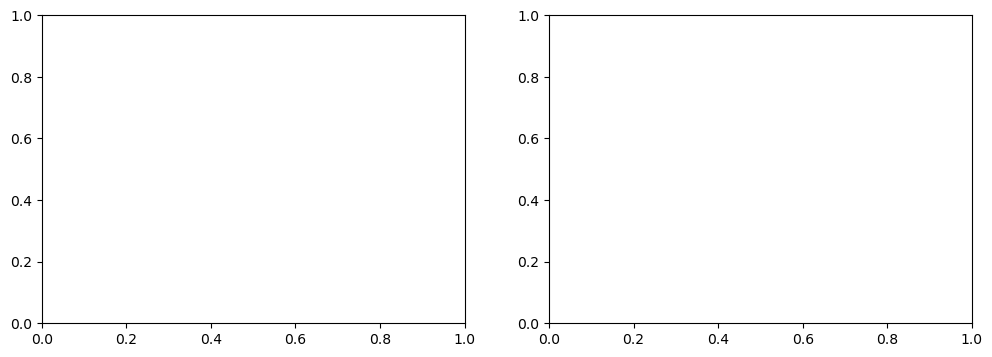

In [ ]:
df_cm = pd.DataFrame(str_array, index = [str(w) for w in workers_list],
                  columns = [str(t) for t in threads_list])

#plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(df_cm, annot=True, ax=ax1)
ax1.set_xlabel('Number of threads')
ax1.set_ylabel('Number of workers')
ax1.set_title('Time [s]')

for k, t in enumerate(threads_list):
    if k == 1:
        ax2.errorbar(np.array(workers_list)+0.1, mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    else:
        ax2.errorbar(np.array(workers_list), mean[:, k], yerr=std[:, k], label=f'Number of threads {t}', fmt='o--')
    
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Time [s]')
ax2.set_xlabel('Number of workers')
ax2.legend()


# Benchmar Worker Multiprocessing (poor statistic, no real advantage noticed)

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
time_list = np.zeros(shape=(attempt, len(workers_list), len(threads_list)))

for a in range(attempt):
    for w,_ in enumerate(workers_list):
        for t,_ in enumerate(threads_list):
            print('a:', a, '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])
            
            #cluster up
            cluster = SSHCluster(
            ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
            connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
            worker_options={"n_workers": workers_list[w],
                            "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
            scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                )
            client=Client(cluster)
            dask.config.set({'distributed.worker.multiprocessing-method': 'spawn'})

            #begin time
            time_i = time.time()
            
            #function loop
            n_threads_DEMO = 30
            bhbh_list=[]
            for dir_name in dir_list[:1]:
                for i in range(n_threads_DEMO):
                    _ = dask.delayed(FGpreprocessing)(dir_name, i,  output_column_to_remove, evolved_column_to_remove, drop_list)
                    bhbh_list.append(_)

            results = dask.compute(*bhbh_list) 
            results= dask.compute(*results)

            #end time
            time_f = time.time()
            
            #time difference allocation
            time_list[a, w, t] = time_f - time_i

            #cluster down
            cluster.close()
            
#Save the result
np.save('Bench_files/bench_worker_multiprocessing.npy', time_list)

a: 0 	 w: 4 	 t: 4


2023-06-16 08:22:06,766 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,762 - distributed.scheduler - INFO - State start
2023-06-16 08:22:06,772 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:06,770 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-16 08:22:07,829 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,827 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35787'
2023-06-16 08:22:07,854 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,852 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:36479'
2023-06-16 08:22:07,859 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,856 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35857'
2023-06-16 08:22:07,864 - distributed.deploy.ssh - INFO - 2023-06-16 08:22:07,860 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:33245'
2023-06-16 08:22:08,746 - distributed.deploy.ssh - INFO - 2023-06-16

a: 1 	 w: 4 	 t: 4


2023-06-16 08:25:26,278 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,277 - distributed.scheduler - INFO - State start
2023-06-16 08:25:26,299 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,298 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xmdvrdnz', purging
2023-06-16 08:25:26,397 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,396 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iw1hwwso', purging
2023-06-16 08:25:26,412 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,411 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qh8t12kx', purging
2023-06-16 08:25:26,427 - distributed.deploy.ssh - INFO - 2023-06-16 08:25:26,426 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhl0eg7i', purging
2023-06-16 08:25:26,442 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 w: 4 	 t: 4


2023-06-16 08:28:45,745 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,744 - distributed.scheduler - INFO - State start
2023-06-16 08:28:45,814 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:45,813 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-po_y4bep', purging
2023-06-16 08:28:46,105 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,104 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hgbd5zvg', purging
2023-06-16 08:28:46,107 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,105 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s2z5dgvi', purging
2023-06-16 08:28:46,111 - distributed.deploy.ssh - INFO - 2023-06-16 08:28:46,110 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-02ds7uip', purging
2023-06-16 08:28:46,126 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 w: 4 	 t: 4


2023-06-16 08:32:21,079 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,077 - distributed.scheduler - INFO - State start
2023-06-16 08:32:21,134 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,132 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x89xj2f8', purging
2023-06-16 08:32:21,141 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,140 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hb98jwx0', purging
2023-06-16 08:32:21,151 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,150 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6mwemqqx', purging
2023-06-16 08:32:21,157 - distributed.deploy.ssh - INFO - 2023-06-16 08:32:21,156 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yzfbey3q', purging
2023-06-16 08:32:21,163 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 w: 4 	 t: 4


2023-06-16 08:35:44,840 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,837 - distributed.scheduler - INFO - State start
2023-06-16 08:35:44,855 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,853 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zyjv3osx', purging
2023-06-16 08:35:44,883 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,881 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yy1i_bla', purging
2023-06-16 08:35:44,885 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,884 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gwjfjl5s', purging
2023-06-16 08:35:44,889 - distributed.deploy.ssh - INFO - 2023-06-16 08:35:44,885 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-uxsq9qb7', purging
2023-06-16 08:35:44,894 - distributed.deploy.ssh - INFO - 2023-06

In [ ]:
array = np.load('Bench_files/bench_worker_multiprocessing.npy')
array

array([[[185.79968929]],

       [[187.40345001]],

       [[202.63205862]],

       [[190.16853452]],

       [[199.01239634]]])

In [ ]:
mean, std = np.mean(array), np.std(array)

In [ ]:
print(str(mean) + ' +/- ' + str(std), 'vs', '253 +/- 65')

193.00322575569152 +/- 6.6348843812235545 vs 253 +/- 65


# Benchmark with partitions for output (1, 12, 24)

In [ ]:
def FGpreprocessing_partitions(dir_path: str, n_thread: int, output_column_to_remove: list,
                               evolved_column_to_remove: list, drop_list: list, n_part: int): 
    
    output_str = f'{dir_path}/0/output_{n_thread}.csv'
    evolved_str = f'{dir_path}/0/evolved_{n_thread}.dat'
    logfile_str = f'{dir_path}/0/logfile_{n_thread}.dat'
    
#    Z_0 = float(re.findall(r".+((?<=Z)\d.\d+)", output_str)[0]) # in teoria non serve perchè Z_0 lo si prende negli evloved
    alpha = float(re.findall(r".+(?<=A)(.*)(?=L)", output_str)[0])
    ################################
    output = dd.read_csv(output_str).\
                rename(columns={'Mass_0':'Mass_0_out', 'Mass_1':'Mass_1_out'}).\
                drop(columns=output_column_to_remove).\
                repartition(npartitions = n_part)


    idxBHBH=(output.RemnantType_0==6) & (output.RemnantType_1==6) & (output.Semimajor.notnull())
    output=output[idxBHBH] #Distributed DataFrame containing only binaries BB

    ################################         

    evolved = dd.read_table(evolved_str, sep='\s+').\
                drop(columns=evolved_column_to_remove)
    
    evolved['alpha'] = alpha
    ################################

    logfile = dd.read_csv(logfile_str, header=None)

    df_RLO = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);RLO_BEGIN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='RLO').\
                reset_index()

    df_CE = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);CE;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='CE').\
                reset_index()

    df_BSN = logfile[0].str.extract(r"B;((?:\d*\_)?\d+);(\d+);BSN;").\
                dropna().\
                rename(columns={0:'name', 1:'ID'}).\
                groupby(['name']).\
                size().to_frame(name='BSN').\
                reset_index()


    ################################

    bhbh = evolved.merge(output, on=['name'], how='inner').\
                   merge(df_RLO, on=['name'], how='left').\
                   merge(df_CE,  on=['name'], how='left').\
                   merge(df_BSN, on=['name'], how='left').\
                   fillna(value=0).\
                   drop(columns=drop_list)

    ###############################

    bhbh['tdelay'] = bhbh['GWtime'] + bhbh['BWorldtime']

    bhbh['Mass_max_out'] = bhbh['Mass_1_out']
    bhbh['Mass_max_out'] = bhbh['Mass_max_out'].\
                            where(cond=(bhbh['Mass_max_out'] > bhbh['Mass_0_out']), other=bhbh['Mass_0_out'])

    bhbh['q'] = bhbh['Mass_1_out']/bhbh['Mass_0_out']
    bhbh['q'] = bhbh['q'].\
                where(cond=(bhbh['Mass_1_out'] < bhbh['Mass_0_out']), other=bhbh['Mass_0_out']/bhbh['Mass_1_out'])

    bhbh['Mass_chirp'] = ((bhbh['Mass_0_out'] * bhbh['Mass_1_out'])**(3/5))/((bhbh['Mass_0_out'] + bhbh['Mass_1_out'])**(1/5))
    
    return bhbh

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Benchmark_divisions.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4


2023-06-10 16:30:48,609 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,608 - distributed.scheduler - INFO - State start
2023-06-10 16:30:48,611 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,609 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-za9e9b09', purging
2023-06-10 16:30:48,612 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,610 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s5ksk1s0', purging
2023-06-10 16:30:48,615 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gsazhn76', purging
2023-06-10 16:30:48,616 - distributed.deploy.ssh - INFO - 2023-06-10 16:30:48,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-x6y027y3', purging
2023-06-10 16:30:48,618 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark divisions

d_1     175.983450
d_2     221.797806
d_12    241.021792
dtype: float64
d_1     13.033073
d_2     22.764691
d_12    22.366035
dtype: float64


Text(0.5, 1.0, 'Benchmark divisions')

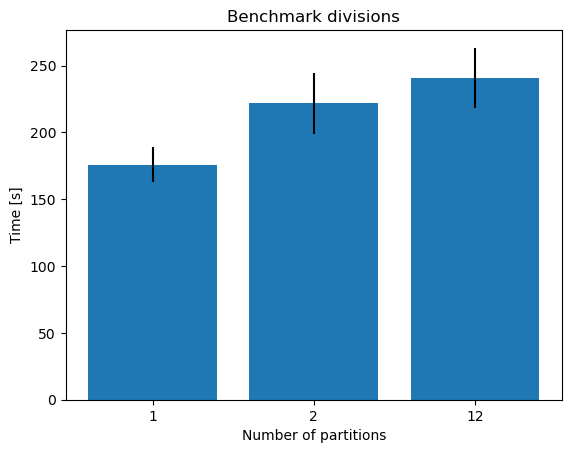

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1, 2, 12] #to br change in the plot in [1,12,24]
array = np.load('Benchmark_divisions.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

array = array.reshape((5, 3))
df = pd.DataFrame(array, columns=['d_1', 'd_2', 'd_12'])
print(df.mean(axis=0))
print(df.std(axis=0))

fig,ax = plt.subplots()
ax.bar(x=['1', '2', '12'], height=df.mean(axis=0), yerr=df.std(axis=0))
ax.set_xlabel('Number of partitions')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark divisions')

# Benchmark number of directory (there is a mistake in the number of directory n, now it has checked n=[0,1,2,3] because of the range(len(number_of_directory))

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [1,2,3,4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for n in range(len(number_directory_list)):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', number_directory_list[n])

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:n]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, n] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Benchmark_directory.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 18:52:52,384 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,382 - distributed.scheduler - INFO - State start
2023-06-10 18:52:52,388 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,384 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-frhs3hq1', purging
2023-06-10 18:52:52,389 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,385 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xqpux7kj', purging
2023-06-10 18:52:52,392 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,386 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gjb3zpq_', purging
2023-06-10 18:52:52,393 - distributed.deploy.ssh - INFO - 2023-06-10 18:52:52,387 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-3_98msfo', purging
2023-06-10 18:52:52,395 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 18:53:02,321 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,320 - distributed.scheduler - INFO - State start
2023-06-10 18:53:02,324 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,322 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4m4aon0w', purging
2023-06-10 18:53:02,326 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,324 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-efwfhmjw', purging
2023-06-10 18:53:02,328 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,326 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-96ahu_ij', purging
2023-06-10 18:53:02,329 - distributed.deploy.ssh - INFO - 2023-06-10 18:53:02,328 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bwjp2el8', purging
2023-06-10 18:53:02,337 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 18:56:11,511 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,509 - distributed.scheduler - INFO - State start
2023-06-10 18:56:11,513 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,511 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-upjk8ikp', purging
2023-06-10 18:56:11,517 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,517 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0g0uol04', purging
2023-06-10 18:56:11,525 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,524 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mgytvgtc', purging
2023-06-10 18:56:11,530 - distributed.deploy.ssh - INFO - 2023-06-10 18:56:11,529 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6m5jwu_9', purging
2023-06-10 18:56:11,536 - distributed.deploy.ssh - INFO - 2023-06

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:01:45,216 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,215 - distributed.scheduler - INFO - State start
2023-06-10 19:01:45,226 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,225 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oabhk91b', purging
2023-06-10 19:01:45,243 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,241 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-cnu6x5qv', purging
2023-06-10 19:01:45,245 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,242 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-exzx9vbk', purging
2023-06-10 19:01:45,247 - distributed.deploy.ssh - INFO - 2023-06-10 19:01:45,243 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-iltqm_j4', purging
2023-06-10 19:01:45,257 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:11:26,462 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,461 - distributed.scheduler - INFO - State start
2023-06-10 19:11:26,481 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,480 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-35ks9ikf', purging
2023-06-10 19:11:26,488 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-qtbnv93v', purging
2023-06-10 19:11:26,489 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,487 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q9__i13_', purging
2023-06-10 19:11:26,492 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:26,491 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bqx3w6ss', purging
2023-06-10 19:11:26,500 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:11:33,990 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:33,988 - distributed.scheduler - INFO - State start
2023-06-10 19:11:34,039 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,037 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o3r5755o', purging
2023-06-10 19:11:34,041 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,038 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-g7p32_0x', purging
2023-06-10 19:11:34,042 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-syvvqsd0', purging
2023-06-10 19:11:34,044 - distributed.deploy.ssh - INFO - 2023-06-10 19:11:34,039 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f6tigl2n', purging
2023-06-10 19:11:34,048 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:14:29,888 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,886 - distributed.scheduler - INFO - State start
2023-06-10 19:14:29,896 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,894 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9zdwo6ge', purging
2023-06-10 19:14:29,899 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,895 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0srrtnju', purging
2023-06-10 19:14:29,900 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,896 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-zeo7wlfy', purging
2023-06-10 19:14:29,901 - distributed.deploy.ssh - INFO - 2023-06-10 19:14:29,897 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0nivgn2k', purging
2023-06-10 19:14:29,936 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:20:05,060 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,058 - distributed.scheduler - INFO - State start
2023-06-10 19:20:05,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fe6iluv1', purging
2023-06-10 19:20:05,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mho_gnk2', purging
2023-06-10 19:20:05,074 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a570a1gf', purging
2023-06-10 19:20:05,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:20:05,070 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ooolqfqd', purging
2023-06-10 19:20:05,084 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:28:22,392 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,390 - distributed.scheduler - INFO - State start
2023-06-10 19:28:22,406 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,405 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4fhwn7bn', purging
2023-06-10 19:28:22,436 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,434 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-0x01fcmm', purging
2023-06-10 19:28:22,443 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,442 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ysam46sz', purging
2023-06-10 19:28:22,445 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:22,443 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fu0ywcjm', purging
2023-06-10 19:28:22,452 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:28:29,824 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,823 - distributed.scheduler - INFO - State start
2023-06-10 19:28:29,830 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-v7443xab', purging
2023-06-10 19:28:29,832 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,825 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-701alvl_', purging
2023-06-10 19:28:29,834 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-940bdza_', purging
2023-06-10 19:28:29,841 - distributed.deploy.ssh - INFO - 2023-06-10 19:28:29,826 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-074_ixyc', purging
2023-06-10 19:28:29,842 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:31:22,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,649 - distributed.scheduler - INFO - State start
2023-06-10 19:31:22,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,651 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i5_w6c54', purging
2023-06-10 19:31:22,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rddywufm', purging
2023-06-10 19:31:22,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,652 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ejr3929u', purging
2023-06-10 19:31:22,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:31:22,653 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6oii9s0b', purging
2023-06-10 19:31:22,717 - distributed.deploy.ssh - INFO - 2023-06

a: 2 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:36:23,524 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,523 - distributed.scheduler - INFO - State start
2023-06-10 19:36:23,541 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,539 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fn1itlfa', purging
2023-06-10 19:36:23,599 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8zd7f7n0', purging
2023-06-10 19:36:23,606 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,605 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-p6dngpo9', purging
2023-06-10 19:36:23,609 - distributed.deploy.ssh - INFO - 2023-06-10 19:36:23,607 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oelgh_0v', purging
2023-06-10 19:36:23,615 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:43:41,067 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,065 - distributed.scheduler - INFO - State start
2023-06-10 19:43:41,070 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,067 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-y_tqv3l1', purging
2023-06-10 19:43:41,073 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,068 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9463pid_', purging
2023-06-10 19:43:41,076 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,069 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-2l57wkmw', purging
2023-06-10 19:43:41,077 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:41,071 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-re23dx_d', purging
2023-06-10 19:43:41,082 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:43:47,647 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,646 - distributed.scheduler - INFO - State start
2023-06-10 19:43:47,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,654 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-8qzhfj2y', purging
2023-06-10 19:43:47,657 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-do26w1tc', purging
2023-06-10 19:43:47,658 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,655 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-umnsjy0j', purging
2023-06-10 19:43:47,659 - distributed.deploy.ssh - INFO - 2023-06-10 19:43:47,656 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bmo9aqd_', purging
2023-06-10 19:43:47,661 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 19:46:29,943 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,942 - distributed.scheduler - INFO - State start
2023-06-10 19:46:29,951 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,950 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-l9u3iy6i', purging
2023-06-10 19:46:29,953 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,951 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f28aueqo', purging
2023-06-10 19:46:29,955 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,952 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1x0uc7p6', purging
2023-06-10 19:46:29,961 - distributed.deploy.ssh - INFO - 2023-06-10 19:46:29,961 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-e0jehsr8', purging
2023-06-10 19:46:29,967 - distributed.deploy.ssh - INFO - 2023-06

a: 3 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 19:51:19,423 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,421 - distributed.scheduler - INFO - State start
2023-06-10 19:51:19,434 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,432 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-mbr8fc27', purging
2023-06-10 19:51:19,446 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,445 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bu4gzx0k', purging
2023-06-10 19:51:19,454 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,453 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-72xvn65t', purging
2023-06-10 19:51:19,456 - distributed.deploy.ssh - INFO - 2023-06-10 19:51:19,455 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-oifzidto', purging
2023-06-10 19:51:19,463 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 1


2023-06-10 19:58:31,132 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,131 - distributed.scheduler - INFO - State start
2023-06-10 19:58:31,147 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,145 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-gh6pkn5w', purging
2023-06-10 19:58:31,156 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,155 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rjv1gmj1', purging
2023-06-10 19:58:31,161 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,160 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-xk1r_e06', purging
2023-06-10 19:58:31,164 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:31,162 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-lxw95059', purging
2023-06-10 19:58:31,170 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 2


2023-06-10 19:58:38,643 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,642 - distributed.scheduler - INFO - State start
2023-06-10 19:58:38,648 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,643 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-psm_c8ti', purging
2023-06-10 19:58:38,651 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,644 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-o9cacubu', purging
2023-06-10 19:58:38,655 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ebrmf1kx', purging
2023-06-10 19:58:38,656 - distributed.deploy.ssh - INFO - 2023-06-10 19:58:38,645 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-k03qy6ac', purging
2023-06-10 19:58:38,657 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 3


2023-06-10 20:01:22,537 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,536 - distributed.scheduler - INFO - State start
2023-06-10 20:01:22,541 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,538 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yez1v_lh', purging
2023-06-10 20:01:22,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-i6ejebgt', purging
2023-06-10 20:01:22,550 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhcp8kgq', purging
2023-06-10 20:01:22,551 - distributed.deploy.ssh - INFO - 2023-06-10 20:01:22,548 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ydpzswlm', purging
2023-06-10 20:01:22,554 - distributed.deploy.ssh - INFO - 2023-06

a: 4 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:06:01,502 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,500 - distributed.scheduler - INFO - State start
2023-06-10 20:06:01,548 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,547 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-n4fl32df', purging
2023-06-10 20:06:01,600 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,598 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ew6i70nj', purging
2023-06-10 20:06:01,602 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,600 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_axnxr_m', purging
2023-06-10 20:06:01,605 - distributed.deploy.ssh - INFO - 2023-06-10 20:06:01,601 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dhrs_pc7', purging
2023-06-10 20:06:01,609 - distributed.deploy.ssh - INFO - 2023-06

## Plot Benchmark directory

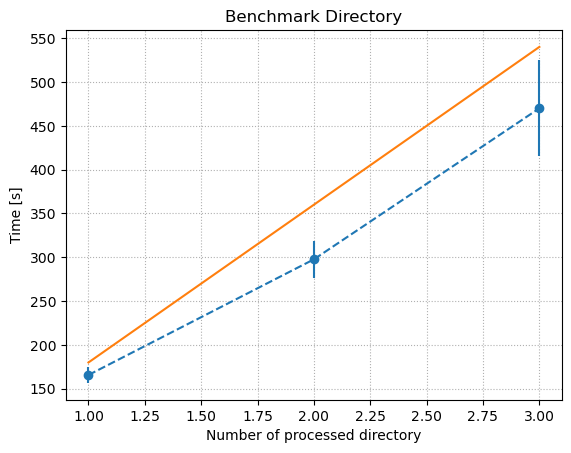

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3]

array = np.load('Bench_files/Benchmark_directory.npy')

mean = np.mean(array, axis = 0)
std = np.std(array, axis = 0)

fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')

## Correcting mistake, running the loop for 4 directory 

In [ ]:
attempt = 5
workers_list = [4]
threads_list = [4]
divisions_list = [1] #to be defined
number_directory_list = [4]

time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list), len(number_directory_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                for k, n in enumerate(number_directory_list):
                    print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t],
                         '\t','n:', n)

                    #cluster up
                    cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": workers_list[w],
                                    "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
                    client=Client(cluster)

                    #begin time
                    time_i = time.time()

                    #function loop
                    n_threads_DEMO = 30
                    bhbh_list=[]
                    for dir_name in dir_list[:n]:
                        for i in range(n_threads_DEMO):
                            _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                              drop_list, n_part=divisions_list[d])
                            bhbh_list.append(_)

                    results = dask.compute(*bhbh_list) 
                    results= dask.compute(*results)

                    #end time
                    time_f = time.time()

                    #time difference allocation
                    time_list[a, d, w, t, k] = time_f - time_i

                    #cluster down
                    cluster.close()
            
#Save the result
np.save('Benchmark_4_directory.npy', time_list)

a: 0 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:39:24,169 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,167 - distributed.scheduler - INFO - State start
2023-06-10 20:39:24,174 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,169 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a3aatibd', purging
2023-06-10 20:39:24,341 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,340 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1wukrpef', purging
2023-06-10 20:39:24,356 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,355 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-szhzl7yb', purging
2023-06-10 20:39:24,361 - distributed.deploy.ssh - INFO - 2023-06-10 20:39:24,360 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h7ft5ym9', purging
2023-06-10 20:39:24,366 - distributed.deploy.ssh - INFO - 2023-06

a: 1 	 d: 1 	 w: 4 	 t: 4 	 n: 4


2023-06-10 20:47:46,960 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,958 - distributed.scheduler - INFO - State start
2023-06-10 20:47:46,980 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,979 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-81u_02f6', purging
2023-06-10 20:47:46,989 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,988 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bhf7fiot', purging
2023-06-10 20:47:46,991 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,990 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pa1kp3zq', purging
2023-06-10 20:47:46,994 - distributed.deploy.ssh - INFO - 2023-06-10 20:47:46,993 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1fgpptp5', purging
2023-06-10 20:47:47,000 - distributed.deploy.ssh - INFO - 2023-06

## Patch plot

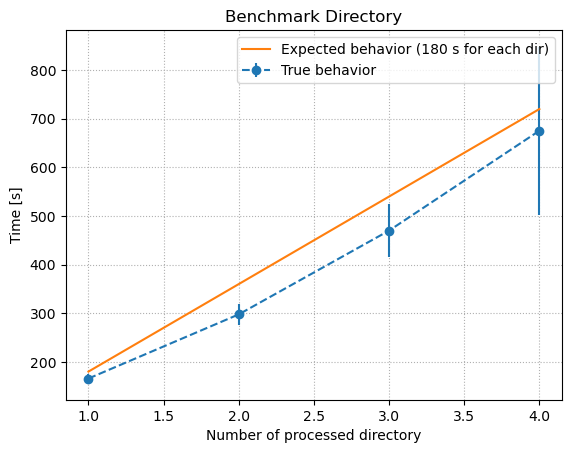

In [ ]:
workers_list = [4]
threads_list = [4]
divisions_list = [1]
number_directory_list = [1,2,3,4]

array_1 = np.load('Bench_files/Benchmark_directory.npy')
mean_1 = np.mean(array_1, axis = 0)
std_1 = np.std(array_1, axis = 0)

array_2 = np.load('Bench_files/Benchmark_4_directory.npy')
mean_2 = np.mean(array_2, axis = 0)
std_2 = np.std(array_2, axis = 0)

mean = np.concatenate((mean_1, mean_2), axis=3)
std = np.concatenate((std_1, std_2), axis=3)


fig, ax = plt.subplots()
ax.errorbar(x=number_directory_list, y=mean[0,0,0,1:], yerr=std[0,0,0,1:], fmt='o--', label='True behavior')
ax.plot(number_directory_list, np.array(number_directory_list)*180, label='Expected behavior (180 s for each dir)')
ax.set_xlabel('Number of processed directory')
ax.set_ylabel('Time [s]')
ax.set_title('Benchmark Directory')
ax.grid(linestyle='dotted')
ax.legend()

# Benchmark read_time sync

In [ ]:
cluster = SSHCluster(
                    ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                        )
client=Client(cluster)

2023-06-10 16:21:37,120 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,119 - distributed.scheduler - INFO - State start
2023-06-10 16:21:37,151 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:37,150 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-10 16:21:38,165 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,164 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42467'
2023-06-10 16:21:38,176 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,174 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:42371'
2023-06-10 16:21:38,186 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,182 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38239'
2023-06-10 16:21:38,199 - distributed.deploy.ssh - INFO - 2023-06-10 16:21:38,198 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:35007'
2023-06-10 16:21:39,074 - distributed.deploy.ssh - INFO - 2023-06-10

In [ ]:
output = dd.read_csv(dir_list[0]+'/0/output_*.csv')
output.columns

Index(['ID', 'name', 'Mass_0', 'MHE_0', 'MCO_0', 'Radius_0', 'RHE_0', 'RCO_0',
       'Luminosity_0', 'Temperature_0', 'Lambda_0', 'Phase_0', 'PhaseBSE_0',
       'RemnantType_0', 'Zams_0', 'Mass_1', 'MHE_1', 'MCO_1', 'Radius_1',
       'RHE_1', 'RCO_1', 'Luminosity_1', 'Temperature_1', 'Lambda_1',
       'Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Zams_1', 'Semimajor',
       'Eccentricity', 'GWtime', 'BWorldtime', 'BEvent'],
      dtype='object')

In [ ]:
%%time
mean_output = output['name'].count()
mean = dask.compute(mean_output)

CPU times: user 662 ms, sys: 120 ms, total: 782 ms
Wall time: 3min 42s


# Benchmark Grid search (Thread, workers, partitions)

In [ ]:
attempt = 5
workers_list = [1, 2, 4]
threads_list = [1, 2, 4]
divisions_list = [1, 12, 24]
time_list = np.zeros(shape=(attempt, len(divisions_list), len(workers_list), len(threads_list)))

for a in range(attempt):
    for d in range(len(divisions_list)):
        for w in range(len(workers_list)):
            for t in range(len(threads_list)):
                print('a:', a, '\t','d:', divisions_list[d], '\t', 'w:', workers_list[w], '\t','t:', threads_list[t])

                #cluster up
                cluster = SSHCluster(
                ["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                worker_options={"n_workers": workers_list[w],
                                "nthreads": threads_list[t]}, # because each bhbh-* has 4 cores
                scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                                    )
                client=Client(cluster)

                #begin time
                time_i = time.time()

                #function loop
                n_threads_DEMO = 30
                bhbh_list=[]
                for dir_name in dir_list[:1]:
                    for i in range(n_threads_DEMO):
                        _ = dask.delayed(FGpreprocessing_partitions)(dir_name, i, output_column_to_remove, evolved_column_to_remove,
                                                          drop_list, n_part=divisions_list[d])
                        bhbh_list.append(_)

                results = dask.compute(*bhbh_list) 
                results= dask.compute(*results)

                #end time
                time_f = time.time()

                #time difference allocation
                time_list[a, d, w, t] = time_f - time_i

                #cluster down
                cluster.close()
            
#Save the result
np.save('Benchmark_GridSearch.npy', time_list)